In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import ast
import requests
from scipy import stats
import seaborn as sns
import datetime
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from empath import Empath
import pyLDAvis.gensim_models
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
from gensim.utils import simple_preprocess

import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go

from helpers import *

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/clarawetzel/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# 0. Loading the data

In [3]:
#load data/moviesummaries/character.metadata.tsv
character_metadata = pd.read_csv('../data/moviesummaries/character.metadata.tsv', sep='\t', header=None)

#load data/moviesummaries/plot_summaries.txt
plot_summaries = pd.read_csv('../data/moviesummaries/plot_summaries.txt', sep='\t', header=None)

#load data/moviesummaries/movie.metadata.tsv
movie_metadata = pd.read_csv('../data/moviesummaries/movie.metadata.tsv', sep='\t', header=None)

#load data/moviesummaries/name.clusters.txt
name_clusters = pd.read_csv('../data/moviesummaries/name.clusters.txt', sep='\t', header=None)


In [4]:
# Rename columns of each dataset to match documentation
character_metadata.columns = ["Wikipedia movie ID", "Freebase movie ID", "Movie release date", "Character name", "Actor date of birth", "Actor gender", 
                              "Actor height", "Actor ethnicity", "Actor name", "Actor age", "Freebase character/actor map ID", 
                              "Freebase character ID", "Freebase actor ID"]

plot_summaries.columns = ["Wikipedia movie ID", "Summary"]

movie_metadata.columns = ["Wikipedia movie ID", "Freebase movie ID", "Movie name", "Movie release date", "Movie revenue", "Movie runtime",
                          "Movie languages", "Movie countries", "Movie genres"]

name_clusters.columns = ["Character name", "Freebase character/actor map ID"]

We get 4 different dataframes; we'll merge movie_metadata and plot_summaries together since it makes sense to get the plot information directly linked with the movie metadata, and keep the others as is.

# 1. Preprocessing plot and metadata about movies

We can see from the columns name that we can simply add the plot summaries of the movies to the movie metadata dataframe. Let's first take a look at how many data we have in each dataset :

In [5]:
# Print the size of plot and meta_data dataset
print("Number of data in the metadata dataframe :", movie_metadata.shape[0])
print("Number of data in the plot summaries dataframe :", plot_summaries.shape[0])

Number of data in the metadata dataframe : 81741
Number of data in the plot summaries dataframe : 42303


We can see that approximately half of the movies in the metadata have a plot description. Let's first check if 'Wikipedia movie ID' can be used as a unique key to merge the two dataframes :

In [6]:
# Find out how many duplicates there are in the datasets
print("Numbers of duplicated Wikipedia movie ID in the metadata dataframe : ", movie_metadata["Wikipedia movie ID"].duplicated().sum())
print("Numbers of duplicated Wikipedia movie ID in the plot summaries dataframe : ", plot_summaries["Wikipedia movie ID"].duplicated().sum())

Numbers of duplicated Wikipedia movie ID in the metadata dataframe :  0
Numbers of duplicated Wikipedia movie ID in the plot summaries dataframe :  0


We can see that there are no duplicates in the Wikipedia movie ID column, so we can use it as a unique key to merge the two dataframes. Let's do it; We merge the two dataframes 'left' on the Wikipedia movie ID column, so that we keep all the movies in the metadata dataframe, even those that doesn't have a plot description.

In [7]:
# Merge 'left' the movie_metadata and plot_summaries dataframes on the Wikipedia movie ID column
all_movies = movie_metadata.merge(plot_summaries, on="Wikipedia movie ID", how="left")
all_movies.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Summary
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",NaN
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",NaN
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",A series of murders of rich young women throug...
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}","Eva, an upper class housewife, becomes frustra..."


In [8]:
# Check the number and percentage of null values in each column of all_movies as well as the number of different values in each column.
all_movies_null = pd.DataFrame(all_movies.isnull().sum(), columns=['Number of null values'])
all_movies_null['Percentage of null values'] = all_movies_null['Number of null values'] / len(all_movies)
all_movies_null['Number of unique values'] = all_movies.nunique()

print(all_movies.shape)
all_movies_null


(81741, 10)


,Number of null values,Percentage of null values,Number of unique values
Wikipedia movie ID,0,0.000000,81741
Freebase movie ID,0,0.000000,81741
Movie name,0,0.000000,75478
Movie release date,6902,0.084437,20389
Movie revenue,73340,0.897224,7362
Movie runtime,20450,0.250180,597
Movie languages,0,0.000000,1817
Movie countries,0,0.000000,2124
Movie genres,0,0.000000,23817
Summary,39537,0.483686,42196


As mentioned above, we see that approximately 48% percent of the movie dataset doesn't have a corresponding plot summary!

But what about dupplicated plot summaries? It's very unlikely that 2 movies have the exact same entry, but let's check that :

In [9]:
# Show plot summary duplicates which are not NaNs
duplicate_plot_movies = all_movies[all_movies.duplicated(subset=['Summary'], keep = False) & all_movies['Summary'].notnull()]

# Print number of plot summaries having at least one duplicate
print("Number of plot summaries having at least one duplicate :", duplicate_plot_movies['Summary'].nunique())

duplicate_plot_movies[['Wikipedia movie ID', 'Movie name', 'Summary']].sort_values(by=['Summary'])


Number of plot summaries having at least one duplicate : 5


,Wikipedia movie ID,Movie name,Summary
4551,14055212,The Trial of Madame X,A woman is thrown out of her home by her jealo...
18993,14022275,Madame X,A woman is thrown out of her home by her jealo...
49381,14037732,Madame X,A woman is thrown out of her home by her jealo...
57569,14051944,Madame X,A woman is thrown out of her home by her jealo...
65014,14053389,Madame X,A woman is thrown out of her home by her jealo...
28621,29481480,Drohi,An orphan Raghav turns into a ruthless contrac...
67464,25493367,Antham,An orphan Raghav turns into a ruthless contrac...
15783,14616220,The Warrens of Virginia,"As the American Civil War begins, Ned Burton l..."
57508,28852030,The Warrens of Virginia,"As the American Civil War begins, Ned Burton l..."
22185,19609453,Amar Deep,Raja was adopted by a criminal don at a very ...


We see that there are 5 different plot summaries that have at least one duplicate! In some cases, the duplicate has the same movie name but in other cases, the duplicate has a different movie name. To try to catch the real duplicates, we'll search for rows that share all the same columns except the IDs columns.

In [10]:
# Check for duplicates on all columns except for the ID columns
check_duplicates = all_movies[all_movies.duplicated(subset=["Movie name", "Movie release date", "Movie revenue", "Movie languages", "Movie genres", "Movie countries", "Movie runtime", "Summary"], keep=False)]

check_duplicates.sort_values(by=["Movie name"])

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Summary
35927,33545359,/m/0hgm4mx,A Sister to Assist 'Er,NaN,NaN,NaN,{},{},"{""/m/05p553"": ""Comedy film""}",NaN
77623,33545325,/m/0hgpm4_,A Sister to Assist 'Er,NaN,NaN,NaN,{},{},"{""/m/05p553"": ""Comedy film""}",NaN
640,32505827,/m/0h1cbks,Dost,NaN,NaN,NaN,"{""/m/03k50"": ""Hindi Language""}","{""/m/03rk0"": ""India""}",{},NaN
75111,32517667,/m/0h1dthj,Dost,NaN,NaN,NaN,"{""/m/03k50"": ""Hindi Language""}","{""/m/03rk0"": ""India""}",{},NaN
7009,9386528,/m/0286tgz,Horizontal Axis,NaN,NaN,NaN,{},{},"{""/m/02hmvc"": ""Short Film""}",NaN
79631,9386447,/m/0286tdx,Horizontal Axis,NaN,NaN,NaN,{},{},"{""/m/02hmvc"": ""Short Film""}",NaN
9911,20695929,/m/051zsk3,My Wife's Family,NaN,NaN,NaN,{},"{""/m/07ssc"": ""United Kingdom""}","{""/m/01z4y"": ""Comedy""}",NaN
22389,20696066,/m/051zc20,My Wife's Family,NaN,NaN,NaN,{},"{""/m/07ssc"": ""United Kingdom""}","{""/m/01z4y"": ""Comedy""}",NaN
6010,31255600,/m/0gjb35n,Woman to Woman,NaN,NaN,NaN,{},{},"{""/m/02l7c8"": ""Romance Film"", ""/m/07s9rl0"": ""D...",NaN
53387,31255791,/m/0gjf1sq,Woman to Woman,NaN,NaN,NaN,{},{},"{""/m/02l7c8"": ""Romance Film"", ""/m/07s9rl0"": ""D...",NaN


We notice that those films have a lot of NaN values, but since they share all the same values we don't have a valid reason not to drop them. That's why we chose to drop one of each pair.

In [11]:
# drop one of each pair of duplicates
all_movies.drop_duplicates(subset=["Movie name", "Movie release date", "Movie revenue", "Movie languages", "Movie genres", "Movie countries", "Movie runtime", "Summary"], inplace=True, keep="first")

## Data cleaning

### Movie release date


Let's now take a look at the movies release dates. By looking at the data, we see 4 cases :
 - The release date is a year 
 - The release date is a month and a year 
 - The release date is a day, a month and a year 
 - The release date is not a number

Let's convert every entry to only a year when it's possible :

Defining three functions checking which format is valid for a specific string

In [12]:
character_metadata.sample(10)

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
330301,14640620,/m/03grk8g,1948-01-08,NaN,1901-09-08,M,NaN,NaN,Kenneth MacDonald,46.0,/m/09j0q_h,NaN,/m/03gs60v
226400,22643381,/m/05zyn93,1921-08-19,Priester,1880-07-03,M,NaN,NaN,Willem Hunsche,NaN,/m/0n1y7qd,/m/0n1y7qh,/m/0m_3r4x
278190,5822025,/m/0f78sd,1999,Giant,1973-05-17,M,2.28,NaN,Matthew McGrory,25.0,/m/0h34gzc,/m/0h34gzf,/m/04b00g
406858,7259925,/m/0kv2fx,1913,NaN,1884-04-28,M,NaN,NaN,William Garwood,NaN,/m/02tb6k3,NaN,/m/0krxsd
223176,7593569,/m/02665zq,1942-09-14,NaN,1879-10-15,F,NaN,NaN,Jane Darwell,NaN,/m/02vd03x,NaN,/m/039nmy
66778,7153837,/m/0h73xq,1993-11-24,NaN,1955-10-27,M,NaN,NaN,Michael Shamus Wiles,38.0,/m/0gby59r,NaN,/m/0gby59w
281161,7148350,/m/0h6tdb,2006-09-28,NaN,NaN,M,NaN,NaN,Peter Callan,NaN,/m/0gdm4xz,NaN,/m/0gdm4y0
36637,35484511,/m/0j9qjvx,1996-10-11,NaN,1969-07-30,F,1.59,/m/03w9bjf,Mandakini,27.0,/m/0mzp6vm,NaN,/m/0bs530
370298,13555251,/m/03c989q,2007-04-17,NaN,1965-11-23,M,1.85,NaN,Don Frye,41.0,/m/0cg5nz9,NaN,/m/05t76c
256184,27612579,/m/0g5sxb4,2012-01-27,Joe Morelli,1972-08-06,M,NaN,NaN,Jason O'Mara,39.0,/m/0gw2tvh,/m/0gwdh3z,/m/09rv9f


Converting the movie release date to keep only the year for the all_movie table :

In [13]:
all_movies = keep_the_year(all_movies, key='Movie release date')

### Dictionnary structures

In [14]:
# Print examples of the 'Movie countries', 'Movie genres' and 'Movie languages' columns as well as their types
print(all_movies['Movie countries'].iloc[0])
print(type(all_movies['Movie countries'].iloc[0]))
print(all_movies['Movie genres'].iloc[0])
print(type(all_movies['Movie genres'].iloc[0]))
print(all_movies['Movie languages'].iloc[0])
print(type(all_movies['Movie languages'].iloc[0]))

{"/m/09c7w0": "United States of America"}
<class 'str'>
{"/m/01jfsb": "Thriller", "/m/06n90": "Science Fiction", "/m/03npn": "Horror", "/m/03k9fj": "Adventure", "/m/0fdjb": "Supernatural", "/m/02kdv5l": "Action", "/m/09zvmj": "Space western"}
<class 'str'>
{"/m/02h40lc": "English Language"}
<class 'str'>


We see that some columns are written as a dictionnary but saved as a string. 

Three columns are concerned by this problem:
- Movie languages (Freebase ID:name tuples)
- Movie countries (Freebase ID:name tuples)
- Movie genres (Freebase ID:name tuples)

Since we will not use the Freebase IDs, let's only keep the values of these dicts as lists.

In [15]:
all_movies['Movie genres'] = [list(eval(genre).values()) for genre in all_movies['Movie genres']]
all_movies['Movie languages'] = [list(eval(genre).values()) for genre in all_movies['Movie languages']]
all_movies['Movie countries'] = [list(eval(genre).values()) for genre in all_movies['Movie countries']]
print(all_movies['Movie countries'].iloc[0])
print(type(all_movies['Movie countries'].iloc[0]))
print(all_movies['Movie genres'].iloc[0])
print(type(all_movies['Movie genres'].iloc[0]))
print(all_movies['Movie languages'].iloc[0])
print(type(all_movies['Movie languages'].iloc[0]))

['United States of America']
<class 'list'>
['Thriller', 'Science Fiction', 'Horror', 'Adventure', 'Supernatural', 'Action', 'Space western']
<class 'list'>
['English Language']
<class 'list'>


Now, we have a proper dataframe containing metadata and plot summaries about movies: all_movies

# 2. Preprocessing characters metadata

In [16]:
character_metadata.sample(10)

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
9048,1055466,/m/0422v0,1996-04-03,Jack Connerman,1964-12-23,M,NaN,NaN,Reg Rogers,31.0,/m/0gdlp_t,/m/0h5v6j2,/m/0gdk756
189476,18120048,/m/04cvn85,2008-05-25,Le maître de cérémonie,1941,M,NaN,NaN,Mahmoud Mabsout,67.0,/m/0jycg02,/m/0jycg05,/m/0jvq2n
7014,142457,/m/011yqc,1997-05-14,Marilyn Monroe,1974,F,NaN,NaN,Nectar Rose,23.0,/m/05kk469,/m/040c1zc,/m/03cr__3
235749,11030287,/m/02qymtf,2008,NaN,NaN,M,NaN,NaN,Matthew Le Nevez,NaN,/m/0gxdrd8,NaN,/m/0k650m
184845,34152774,/m/0hr418b,1985-02-07,NaN,1936-12-08,M,1.85,/m/07bch9,David Carradine,48.0,/m/0hv_tx6,NaN,/m/02p5hf
383606,15268349,/m/03hnnsb,2005-12-04,Alison,NaN,F,1.73,NaN,Sarah-Jane Redmond,NaN,/m/0cg3c2v,/m/0mzr68r,/m/0dtrmq
293153,31087600,/m/0gh6s_3,2011-01-22,NaN,1932-04-01,F,1.57,/m/07hwkr,Debbie Reynolds,78.0,/m/0h11s_0,NaN,/m/01mmslz
56708,30351490,/m/09rmm4w,1937-02-19,Larry Burke,1897-03-27,M,NaN,NaN,Fred Keating,NaN,/m/0hx1pm_,/m/0hx1pn2,/m/0hqp1g_
175819,1274324,/m/04p7q_,2004-12-17,Cristina Moreno,NaN,F,NaN,NaN,Victoria Luna,NaN,/m/0btp8c4,/m/0btp5_2,/m/0btp8cg
253601,844429,/m/03gdbv,1995-02-03,Polischefen,NaN,M,NaN,NaN,Bernt Lindqvist,NaN,/m/0j6m0qn,/m/0j6m0qr,/m/0j6m0qz


Taking a quick look, we see that we encounter the same problem with the "Movie release date" and " Actor date of birth" as seen before. Let's convert every entry to only a year when it's possible :

In [17]:
character_metadata = keep_the_year(character_metadata, key='Movie release date')
character_metadata = keep_the_year(character_metadata, key='Actor date of birth')

# 3. Learning more about the data

### Chronological evolution of movie production

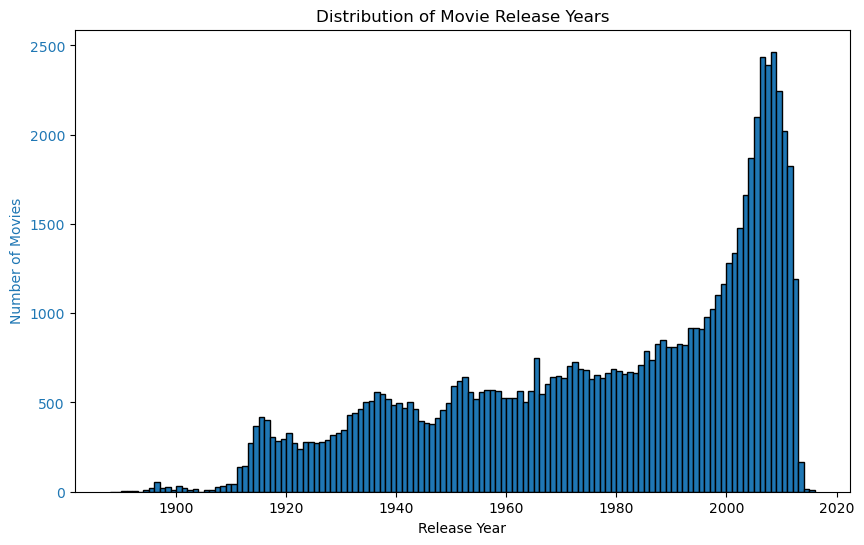

In [18]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Creating an histogram plotting the values of 'year'
ax1.hist(all_movies['Movie release date'].dropna(), bins=range(int(all_movies['Movie release date'].min()), int(all_movies['Movie release date'].max()) + 1), edgecolor='black', label='Movie Releases')
ax1.set_xlabel('Release Year')
ax1.set_ylabel('Number of Movies', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

plt.title('Distribution of Movie Release Years')
plt.show()

Looking at the plot we can see that we have more data for recent films.

### Movie countries and genres

We compute the top 10 countries and genres. For co-produced movies, we count an additional movie per co-producing country. For example, a movie co-produced by the USA and India will add +1 movie produced for both of these countries. The same logic applies for the movie genres.

In [19]:
# Print number of unique movie countries, genres and languages

unique_countries_list = all_movies['Movie countries'].explode().unique()
unique_genres_list = all_movies['Movie genres'].explode().unique()
unique_languages_list = all_movies['Movie languages'].explode().unique()

print('Number of unique movie countries:', len(unique_countries_list))
print('Number of unique movie genres:', len(unique_genres_list))
print('Number of unique movie languages:', len(unique_languages_list))

Number of unique movie countries: 148
Number of unique movie genres: 364
Number of unique movie languages: 208


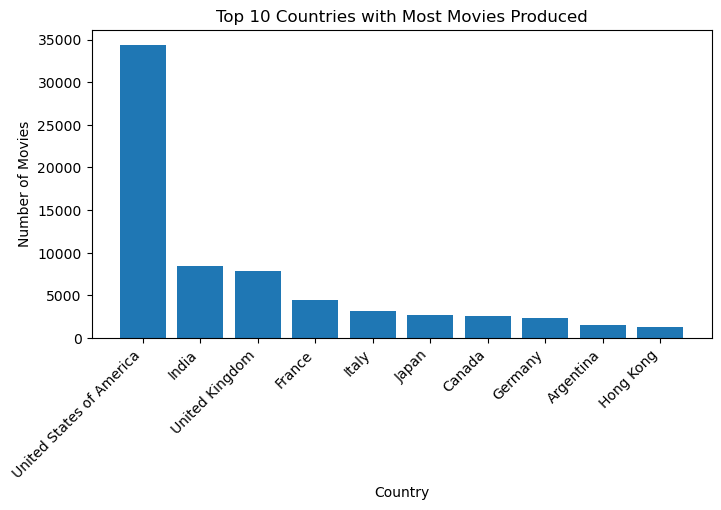

The top production country is United States of America and concerns 39.81% of all movies produced.


In [20]:
# Compute a box plot of top 10 countries with most movies produced or coproduced
country_counts = {}

for countries in all_movies['Movie countries']:
    for country in countries:
        if country in country_counts:
            country_counts[country] += 1
        else:
            country_counts[country] = 1

# Get the top 10 countries
top_countries = sorted(country_counts.items(), key=lambda x: x[1], reverse=True)[:10]

# Create a new DataFrame with the top countries
top_countries_df = pd.DataFrame(top_countries, columns=['Country', 'Count'])

# Bar plot
plt.figure(figsize=(8, 4))
plt.bar(top_countries_df['Country'], top_countries_df['Count'])
plt.xlabel('Country')
plt.ylabel('Number of Movies')
plt.title('Top 10 Countries with Most Movies Produced')
plt.xticks(rotation=45, ha='right')
plt.show()

# Print the top 1 country and its percentage
top_1_country = top_countries_df['Country'].iloc[0]
percentage = country_counts[top_1_country] / sum(country_counts.values()) * 100
print(f'The top production country is {top_1_country} and concerns {percentage:.2f}% of all movies produced.')

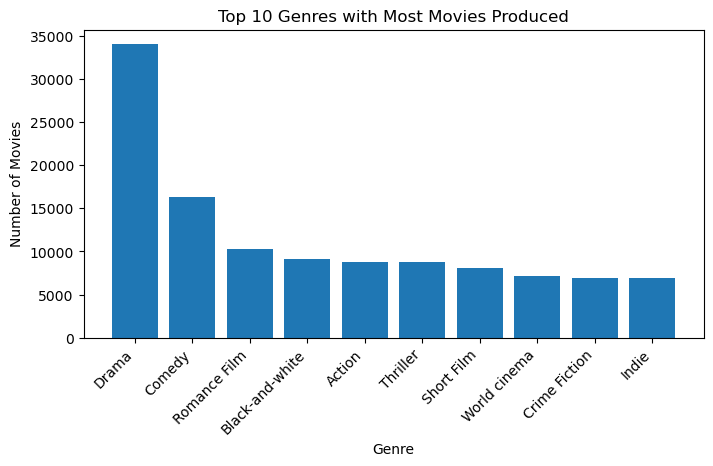

The top genre is Drama and represents 13.98% of all movies produced.


In [21]:
# Compute a box plot of top 10 genres with most movies produced
genre_counts = {}

for genres in all_movies['Movie genres']:
    for genre in genres:
        if genre in genre_counts:
            genre_counts[genre] += 1
        else:
            genre_counts[genre] = 1

# Get the top 10 genres
top_genres = sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)[:10]

# Create a new DataFrame with the top genres
top_genres_df = pd.DataFrame(top_genres, columns=['Genre', 'Count'])

# Bar plot
plt.figure(figsize=(8, 4))
plt.bar(top_genres_df['Genre'], top_genres_df['Count'])
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Top 10 Genres with Most Movies Produced')
plt.xticks(rotation=45, ha='right')
plt.show()

# Print the top 1 genre and its percentage
top_1_genre = top_genres_df['Genre'].iloc[0]
percentage = genre_counts[top_1_genre] / sum(genre_counts.values()) * 100
print(f'The top genre is {top_1_genre} and represents {percentage:.2f}% of all movies produced.')

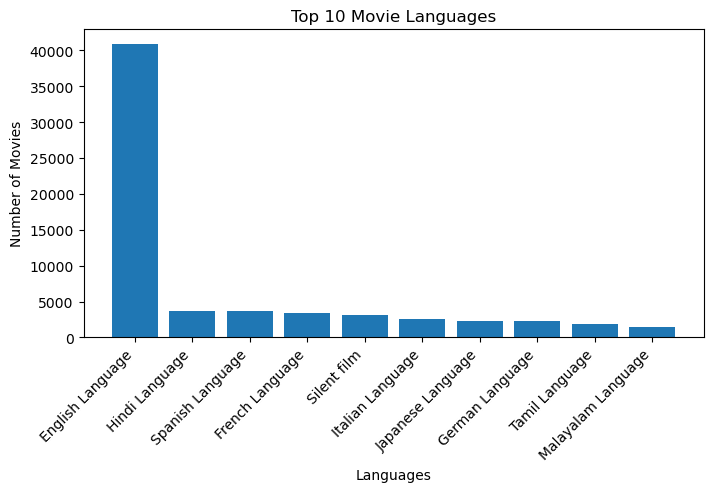

The top language is "English Language" and represents 50.29% of all movies produced.


In [22]:
# Compute a box plot of top 10 genres with most movies produced
language_counts = {}

for languages in all_movies['Movie languages']:
    for language in languages:
        if language in language_counts:
            language_counts[language] += 1
        else:
            language_counts[language] = 1

# Get the top 10 genres
top_languages = sorted(language_counts.items(), key=lambda x: x[1], reverse=True)[:10]

# Create a new DataFrame with the top genres
top_languages_df = pd.DataFrame(top_languages, columns=['Language', 'Count'])

# Bar plot
plt.figure(figsize=(8, 4))
plt.bar(top_languages_df['Language'], top_languages_df['Count'])
plt.xlabel('Languages')
plt.ylabel('Number of Movies')
plt.title('Top 10 Movie Languages')
plt.xticks(rotation=45, ha='right')
plt.show()

# Print the top 1 genre and its percentage
top_1_language = top_languages_df['Language'].iloc[0]
percentage = language_counts[top_1_language] / sum(language_counts.values()) * 100
print(f'The top language is "{top_1_language}" and represents {percentage:.2f}% of all movies produced.')


These results show us that an analysis of the whole dataset will actually be more representative of movies produced or co-produced in the USA, movies belonging to the genre Drama and movies in english. The reason why the percentage of english movies is so high is not only because the USA is the largest producing country but also because a lot of movies might be translated in english.

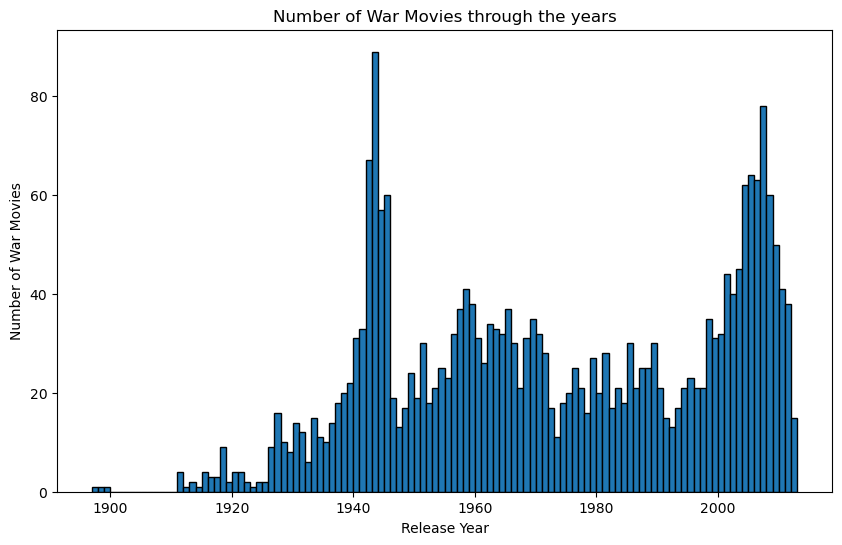

In [23]:
# Selecting columns 'Movie genres' and 'Movie release date'
genre_date = all_movies[['Movie genres', 'Movie release date']]

# Drop rows with missing values in 'Movie genres' column
genre_date = genre_date.dropna(subset=['Movie genres'])

# Explode the 'Movie genres' column
genre_date = genre_date.explode('Movie genres')

# Drop rows with missing values in the exploded 'Movie genres' column
genre_date = genre_date.dropna(subset=['Movie genres'])

# Selecting rows where the movie genre is 'War film'
war_movies = genre_date[genre_date['Movie genres'].str.contains('War film')]

# Reset the index and drop nan values
war_movies = war_movies.reset_index(drop=True).dropna()

#plot the distribution of the number of movies per year for the 'War film' genre
plt.figure(figsize=(10, 6))
plt.hist(war_movies['Movie release date'], bins=range(int(war_movies['Movie release date'].min()), int(war_movies['Movie release date'].max()) + 1), edgecolor='black')
plt.xlabel('Release Year')
plt.ylabel('Number of War Movies')
plt.title('Number of War Movies through the years')
plt.show()

This graph shows the evolution of the number of film about war depending on the years. We can see that there is a first peak around 1945 and a second one around 2010. The first peak could be explained by the Second World War, and the second peak could have several causes, such as the augmentation of the number of terrorist attack in USA and Europe or the augmentation of tension between Russia and USA.

## Missing values

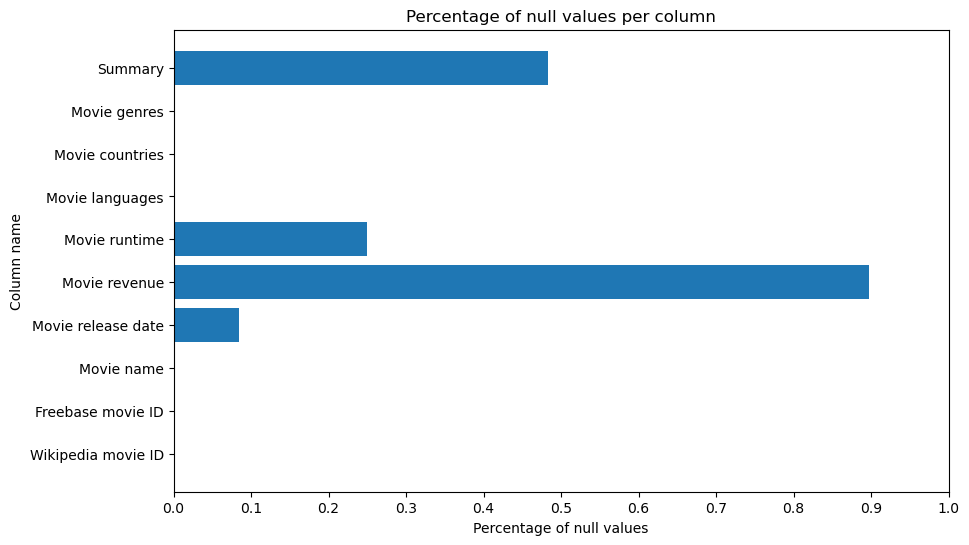

Percentage of missing values in movie revenue: 89.72%


In [24]:
# plot the percentage of missing values for all columns in the all_movies dataframe
plt.figure(figsize=(10, 6))
plt.barh(all_movies_null.index, all_movies_null['Percentage of null values'])
plt.xlabel('Percentage of null values')
plt.ylabel('Column name')
plt.xticks(ticks=np.arange(0, 1.1, 0.1))
plt.title('Percentage of null values per column')
plt.show()

print(f"Percentage of missing values in movie revenue: {100*all_movies_null['Percentage of null values']['Movie revenue']:.2f}%")

We see that there are a lot of missing values of the movie revenues (around 90%), we need to find another metric for judging films popularity. IMDb ratings seem to be a good alternative. This dataset contains the average IMDb rating of movies and the number of votes.

# 4. Add IMDb ratings

### Load the data

In [25]:
movie_ratings = pd.read_csv('../data/title.ratings.tsv', sep='\t', header=0)

In [26]:
movie_ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,2006
1,tt0000002,5.8,269
2,tt0000003,6.5,1909
3,tt0000004,5.5,178
4,tt0000005,6.2,2689


### Use Wikidata query to create a table that links IMDb identifier tconst with Freebase ID

Since multiple movies have the same name and appear the same year, we have to link the two dataset using freebase ID of the movies in the original dataset and the unique identifier tconst of the IMDb ratings dataset. We use Wikidata query to create a link table

In [27]:
# Create the table
link_id = link_tconst_freebaseID()

# Drop duplicates
link_id = link_id.drop_duplicates(subset=['tconst'])
link_id = link_id.drop_duplicates(subset=['Freebase movie ID'])

link_id.head()

,tconst,Freebase movie ID
0,nm3628633,/m/0k83_1r
1,nm0012078,/m/02q173g
2,nm0394250,/m/03kfdk
3,tt0324924,/m/0ct2z8
4,nm0119354,/m/0356cy


### Merge the two datasets

In [28]:
# Add freebase ID to movie_ratings
movie_ratings = pd.merge(movie_ratings, link_id, on='tconst', how='left')
movie_ratings.head()

,tconst,averageRating,numVotes,Freebase movie ID
0,tt0000001,5.7,2006,/m/0kvdsy
1,tt0000002,5.8,269,/m/02pz844
2,tt0000003,6.5,1909,/m/0g53g2
3,tt0000004,5.5,178,/m/02pzdsc
4,tt0000005,6.2,2689,/m/0jq3g


In [29]:
# Merge all_movies and movie_ratings
all_movies = pd.merge(all_movies, movie_ratings, on='Freebase movie ID', how='left')
# Drop tconst column
all_movies.drop(columns=['tconst'], inplace=True)

all_movies.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Summary,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th...",4.9,56908.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",NaN,6.0,69.0
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",NaN,5.6,40.0
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...,6.1,2895.0
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],"Eva, an upper class housewife, becomes frustra...",5.9,623.0


In [30]:
# Percentage of missing values in the columns averageRatings and num votes
print('Percentage of missing values in averageRatings: {:.2f}%'.format(100 * all_movies['averageRating'].isnull().sum() / len(all_movies)))
print('Percentage of missing values in numVotes: {:.2f}%'.format(100 * all_movies['numVotes'].isnull().sum() / len(all_movies)))

Percentage of missing values in averageRatings: 16.99%
Percentage of missing values in numVotes: 16.99%


We have far fewer missing values in ratings than in revenues.

### Correlation between movie revenue and average rating

Percentage of movies for which we have both informations: 10.19% 
 

Person correlation between movie revenue and average rating:  PearsonRResult(statistic=0.1682249182879635, pvalue=6.762172199629691e-54) 
 



/Users/clarawetzel/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


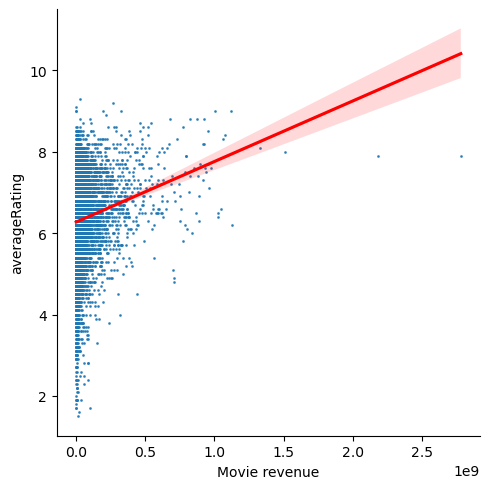

In [31]:
# Keep movies for which we have both informations
df1 = all_movies.dropna(subset=['Movie revenue', 'averageRating'])

# What percentage of the whole dataset does it represent
print("Percentage of movies for which we have both informations: {:.2f}%".format(100 * len(df1) / len(all_movies)), '\n', '\n')

# Pearson correlation between the movie revenue and the average rating
df1_pearson = stats.pearsonr(df1['Movie revenue'], df1['averageRating'])
print("Person correlation between movie revenue and average rating: ", df1_pearson, '\n', '\n')

# Plot the correlation between the movie revenue and the average rating
sns.lmplot(x='Movie revenue', y='averageRating', data=df1, scatter_kws={"s": 1}, line_kws={'color': 'red'})

There is a significant positive correlation between a movie revenue and its average rating.

### Correlation between movie revenue and number of votes for rating

Percentage of movies for which we have both informations: 10.19% 
 

Person correlation between movie revenue and numVotes:  PearsonRResult(statistic=0.6550044723258492, pvalue=0.0) 
 



/Users/clarawetzel/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


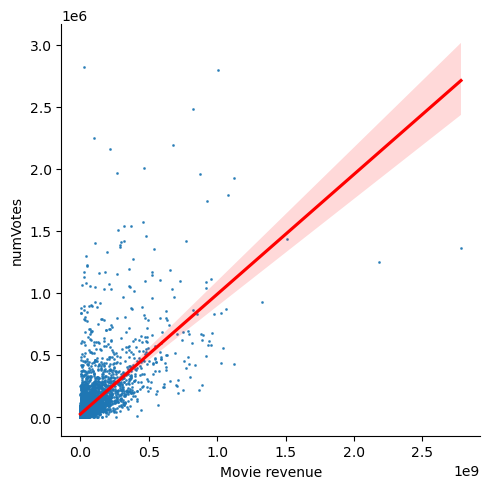

In [32]:
# Keep movies for which we have both informations
df2 = all_movies.dropna(subset=['Movie revenue', 'numVotes'])

# What percentage of the whole dataset does it represent
print("Percentage of movies for which we have both informations: {:.2f}%".format(100 * len(df2) / len(all_movies)), '\n', '\n')

# Pearson correlation between the movie revenue and the average rating
df2_pearson = stats.pearsonr(df2['Movie revenue'], df2['numVotes'])
print("Person correlation between movie revenue and numVotes: ",df2_pearson, '\n', '\n')


# Plot the correlation between the movie revenue and the average rating
sns.lmplot(x='Movie revenue', y='numVotes', data=df2, scatter_kws={"s": 1}, line_kws={'color': 'red'})

There is a significant positive correlation between a movie revenue and its number of votes.

Looking at the previous graphs, the positive correlation between the data confirms that using the movie reviews and number of votes in a similar extent as the movie revenue is reasonable.

# Correlation

### Movie release year - Movie average rating

/var/folders/60/n3wml7t139732y5n5jgc1bqc0000gn/T/ipykernel_40088/148172858.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['Movie release date'] = df3['Movie release date'].astype(int)
/Users/clarawetzel/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)



 
 Percentage of movies for which we have both informations: 77.55% 
 

Person correlation between movie revenue and numVotes:  PearsonRResult(statistic=-0.05528142315912718, pvalue=4.2610827577030967e-44) 
 



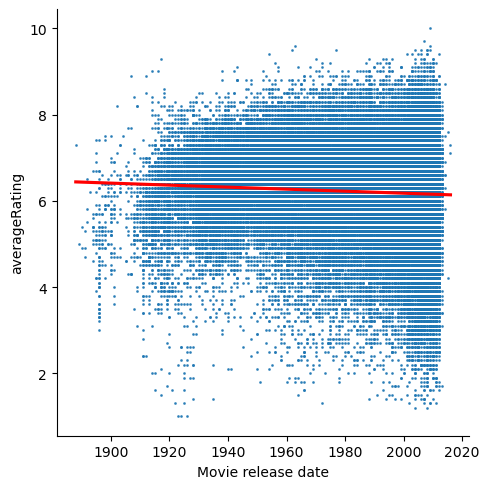

In [33]:
# Keep movies for which we have both informations
df3 = all_movies.dropna(subset=['Movie release date', 'averageRating'])
df3['Movie release date'] = df3['Movie release date'].astype(int)

# What percentage of the whole dataset does it represent
print('\n', '\n', "Percentage of movies for which we have both informations: {:.2f}%".format(100 * len(df3) / len(all_movies)), '\n', '\n')

# Pearson correlation between the movie revenue and the average rating
df3_pearson = stats.pearsonr(df3['Movie release date'], df3['averageRating'])
print("Person correlation between movie revenue and numVotes: ", df3_pearson, '\n', '\n')

# Plot the correlation between the movie revenue and the average rating
sns.lmplot(x='Movie release date', y='averageRating', data=df3, scatter_kws={"s": 1}, line_kws={'color': 'red'})

There is a significative but very weak negative correlation between the two variables.

# NLP Topic detection

In order to point out the main themes in the movie plot summaries, we perform an NLP topic detection analysis. 

## Data cleaning

To perform NLP with a better performance, a few transformation and modification are needed on the summaries. \
We did the following transformations:\
- Tokenization on white space
- Removal of punctuation
- Stopword removal: based on the "english" stopword library from nltk
- Removal of common words in summaries: some words are very common in movie plot summaries (film, films, movie and movies) and don't bring a lot of additional informaiton, we decide to remove them
- Removal of common names: we realized that a lot of topic were described with first names. In our case, it doesn't bring any relevant information. We decide to remove a list of common names in the english language and common names in India.
- Lemmatization

In [34]:
path = '../data/'
all_movies_cleaned, character_metadata_cleaned, name_clusters_cleaned = get_cleaned_data(path)

# CLEANED movie summaries
all_movies_cleaned = all_movies_cleaned.dropna(subset=['Summary']) # ADD DROPNA IN GET_SUMMARIES ?
all_movies_cleaned.head()


Loading the data...
Loading and cleaning the summaries...
Summaries loaded from processed_summaries.tsv
Cleaning the data...
Adding IMDb ratings...


,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Summary,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",half century depicts planet terraformed allowi...,4.9,56908.0
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",series murder woman throughout distinctive sig...,6.1,2895.0
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],upper housewife becomes frustrated leaf arroga...,5.9,623.0
6,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,[English Language],[South Africa],"[Family Film, Fantasy, Adventure, World cinema]",hundred year evil return claim fingall talisma...,NaN,NaN
12,6631279,/m/0gffwj,Little city,1997,NaN,93.0,[English Language],[United States of America],"[Romantic comedy, Ensemble Film, Comedy-drama,...",work cab side hard committing girlfriend want ...,5.8,1129.0


In [35]:
# NOT CLEANED movie summaries (for comparison sake)
# First we copy all_movies and filter to only keep movies with a plot summary
all_movies_not_cleaned = all_movies.copy()
all_movies_not_cleaned = all_movies_not_cleaned.dropna(subset=['Summary'])
all_movies_not_cleaned.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Summary,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th...",4.9,56908.0
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...,6.1,2895.0
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],"Eva, an upper class housewife, becomes frustra...",5.9,623.0
6,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,[English Language],[South Africa],"[Family Film, Fantasy, Adventure, World cinema]","Every hundred years, the evil Morgana returns...",NaN,NaN
12,6631279,/m/0gffwj,Little city,1997,NaN,93.0,[English Language],[United States of America],"[Romantic comedy, Ensemble Film, Comedy-drama,...","Adam, a San Francisco-based artist who works a...",5.8,1129.0


## Topic detection

### Topic detection on the whole dataset

To start our analysis, we perform the topic detection on the whole cleaned dataset.

We see that setting the number of topics to 8 seems to give us the best results.

In [36]:
# Tokenize the text in the 'Summary' column
all_movies_cleaned['Summary_tokens'] = all_movies_cleaned['Summary'].apply(simple_preprocess)

# Create a dictionary from the movie summaries
dictionary = Dictionary(all_movies_cleaned['Summary_tokens'])

# Bag-of-words representation of the documents
corpus = [dictionary.doc2bow(tokens) for tokens in all_movies_cleaned['Summary_tokens']]

# Set up the parameters
seed = 42
params = {'passes': 10, 'random_state': seed}

# Create the LDA model
model = LdaMulticore(corpus=corpus, num_topics=8, id2word=dictionary, workers=6,
                     passes=params['passes'], random_state=params['random_state'])

# plot topics
data =  pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
pyLDAvis.display(data)

KeyboardInterrupt: 

By setting the lambda at 0.5, we see that the main topic genre seems to be:
- Topic 1: Drama/Relationship
- Topic 2: Horror
- Topic 3: Detective/Murder stories
- Topic 4: War
- Topic 5: Musical
- Topic 6: Western
- Topic 7: Supernatural
- Topic 8 : Creatures/animal ?

We also see that war bis part of the top 30 most salient terms.

We see that one of the major societal fear, war, is very represented in our movies as it has a topic on its own.

In [ ]:
#model.show_topics(num_words=5)
#model.show_topic(1,20)

### Topic detection on war movies

Since 'war' seems to be one of the societal fear that is the more represented in our dataset. Let's dive in a more precise analysis of this film. Tp do this, we first need to select all the movies talking about war. We select movies that belong to a genre containing the word 'war' in it.

4 topics

In [ ]:
# Print all possible genres that contain the word "war"
print("All possible genres that contain the word 'war':", all_movies_cleaned['Movie genres'].apply(lambda x: [item for item in x if 'war' in item.lower()]).explode().unique())

# Select movies for which no genre in the list 'Movie genre' contain the word "war"
all_movies_genre_war = all_movies_cleaned[all_movies_cleaned['Movie genres'].apply(lambda x: any(item for item in x if 'war' in item.lower()))]

# Tokenize the text in the 'Summary' column
all_movies_genre_war['Summary_tokens'] = all_movies_genre_war['Summary'].apply(simple_preprocess)

# Create a dictionary from the movie summaries
dictionary = Dictionary(all_movies_genre_war['Summary_tokens'])

# Bag-of-words representation of the documents
corpus = [dictionary.doc2bow(tokens) for tokens in all_movies_genre_war['Summary_tokens']]

# Set up the parameters
seed = 42
params = {'passes': 10, 'random_state': seed}

# Create the LDA model
model = LdaMulticore(corpus=corpus, num_topics=4, id2word=dictionary, workers=6,
                     passes=params['passes'], random_state=params['random_state'])

# plot topics
data =  pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
pyLDAvis.display(data)

All possible genres that contain the word 'war': ['War film' 'Gulf War' 'Anti-war' 'Anti-war film' 'Nuclear warfare'
 'Cold War' 'War effort' 'The Netherlands in World War II']


### Topic detection on non-war movies

Movies about war seem to be very present in our dataset. It is therefore possible that this overrrepresentation of this theme hide other themes about societal fears. To take a closer look to other themes, let's remove the movies about war.

4 topics

In [ ]:
# Select movies for which no genre in the list 'Movie genre' contain the word "war"
all_movies_genre_not_war = all_movies_cleaned[~all_movies_cleaned['Movie genres'].apply(lambda x: any(item for item in x if 'war' in item.lower()))]

# Tokenize the text in the 'Summary' column
all_movies_genre_not_war['Summary_tokens'] = all_movies_genre_not_war['Summary'].apply(simple_preprocess)

# Create a dictionary from the movie summaries
dictionary = Dictionary(all_movies_genre_not_war['Summary_tokens'])

# Bag-of-words representation of the documents
corpus = [dictionary.doc2bow(tokens) for tokens in all_movies_genre_not_war['Summary_tokens']]

# Set up the parameters
seed = 42
params = {'passes': 10, 'random_state': seed}

# Create the LDA model
model = LdaMulticore(corpus=corpus, num_topics=4, id2word=dictionary, workers=6,
                     passes=params['passes'], random_state=params['random_state'])

# plot topics
data =  pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
pyLDAvis.display(data)

/var/folders/60/n3wml7t139732y5n5jgc1bqc0000gn/T/ipykernel_96274/2726125112.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_movies_genre_not_war['Summary_tokens'] = all_movies_genre_not_war['Summary'].apply(simple_preprocess)


KeyboardInterrupt: 

We can define the four topics title as:
- Topic 1: Drama/Relationship/Family
- Topic 2: Action
- Topic 3: Science-fiction/War
- Topic 4: Love/Bollywood movies

By looking at the words appearing in topic 3, we see that some societal fears could be represented in those movies. 

## NLP topic detection (Colin) -> enlever ?

We first try to generate topics from the plot summaries using LDA.

In [ ]:
# CLEANED movie summaries (for comparison sake)
# Create a CountVectorizer for parsing/counting words
count_vectorizer = CountVectorizer()
count_data = count_vectorizer.fit_transform(all_movies_cleaned['Summary'])

# Create and fit the LDA model
lda = LatentDirichletAllocation(n_components=15, random_state=0)
lda.fit(count_data)
print_lda_infos(lda, count_vectorizer, count_data, all_movies_cleaned)

KeyboardInterrupt: 

In [ ]:
# NOT CLEANED movie summaries (for comparison sake)
# Create a CountVectorizer for parsing/counting words
count_vectorizer = CountVectorizer(stop_words='english')
count_data = count_vectorizer.fit_transform(all_movies_not_cleaned['Summary'])

# Create and fit the LDA model
lda = LatentDirichletAllocation(n_components=15, random_state=0)
lda.fit(count_data)
print_lda_infos(lda, count_vectorizer, count_data, all_movies_not_cleaned)

Number of topics:15

Topics found via LDA:
Topic 0:
george money man life father alice tells band old family
Topic 1:
tom house school tells jerry goes home gets night room
Topic 2:
film harry world new crew earth movie time ship story
Topic 3:
johnny jake vampire daniel kim road mary dracula joey su
Topic 4:
police man killed car gang kill murder killer dead escape
Topic 5:
new jim joe money eddie family father home time tells
Topic 6:
war army men david soldiers killed german fight japanese battle
Topic 7:
bugs sam daffy tells away ship tries king wolf just
Topic 8:
mother love life father family young wife woman home new
Topic 9:
love father family life son story daughter gets mother comes
Topic 10:
film ben jimmy john president life kate new story town
Topic 11:
peter anna tells family time christmas scott luke home father
Topic 12:
jack danny max larry tells car ray money later man
Topic 13:
charlie dr fred earth city world monster bond time powers
Topic 14:
prince queen king prin

We see that cleaning the data gives us much more informative topics. From now on, we use only the all_movies_cleaned data.

Giving a quick look at the topics and the genres of the movies associated with them (printed at the end of the lines), we can see that LDA is able to generate topics that are coherent with the genres of the movies. We can attribute the topics the following labels:
- Topic 0: Drama
- Topic 1: Family
- Topic 2: SF
- Topic 3: Horror
- Topic 4: Thriller
- Topic 5: Drama (again)
- Topic 6: Chinese
- Topic 7: Animation
- Topic 8: Drama (again)
- Topic 9: Bollywood
- Topic 10: Politics
- Topic 11: Family/animation
- Topic 12: This one feels unclear
- Topic 13: Superhero
- Topic 14: Japanese/fantasy

There are clearly improvements that can be made. First of all we could consider names as stopwords since we see that a ot of words used to describe the topics are names. Usually this is unwanted. We could also try to use a different number of topics, even though we have already tried different values. Finally we can try to filter out some genres before proceeding to LDA. We show an example next.

In [ ]:
keep = ['Alien Film', 'Alien invasion','Anti-war', 'Anti-war film','Apocalyptic and post-apocalyptic fiction','Cold War', 'Combat Films',
        'Computers', 'Conspiracy fiction', 'Costume Horror', 'Dystopia', 'Environmental Science', 'Future noir', 'Gulf War', 'Natural disaster', 
        'Natural horror films', 'Nuclear warfare', 'Plague', 'Sci-Fi Horror', 'War film', ]

# filter out rows that do not contain any of the genres in the keep list
all_movies_filtered = all_movies_cleaned[all_movies_cleaned['Movie genres'].apply(lambda x: any(item for item in x if item in keep))]

In [ ]:
# Perform LDA on the summaries

# Create a CountVectorizer for parsing/counting words
count_vectorizer = CountVectorizer(stop_words='english')
count_data = count_vectorizer.fit_transform(all_movies_filtered['Summary'])

# Create and fit the LDA model
lda = LatentDirichletAllocation(n_components=10, random_state=0)
lda.fit(count_data)
print_lda_infos(lda, count_vectorizer, count_data, all_movies_filtered)

Number of topics:10

Topics found via LDA:
Topic 0:
return vampire tell attack life castle force kill brother home
Topic 1:
make escape help life begin people time police end try
Topic 2:
war time life love family friend home son year later
Topic 3:
war tank force year army end woman horse british guerrilla
Topic 4:
ship alien crew creature kill escape attack team human boat
Topic 5:
camp prisoner escape soldier men british french war killed woman
Topic 6:
family mother father life child tell return attack son boy
Topic 7:
mission german pilot aircraft japanese attack crew officer british fighter
Topic 8:
crocodile sheep group life love story father return fall young
Topic 9:
soldier men officer order war kill killed tell japanese village
Top documents for each topic:
Topic 0:
[('begin monologue vampire telling story lycans vampire year since war begun set several year built army vampire fight threat begun process exterminating lycans appears someone infected lycan transform werewolf c

# Lexicons


### Romain


In [39]:
lexicon = Empath()

In [ ]:
# Create categories in the lexicon 

# Define terms related to war 
war_terms = ["war", "conflict", "battle", "combat", "military",  "soldier", "army", "weapons", "violence", "warfare", "casualties", "peacekeeping"]
# Create a category for "war" in the lexicon 
lexicon.create_category("war", war_terms)

# Define terms related to climat change
climate_change_terms = [ "global_warming", "greenhouse_gas", "carbon_footprint", "renewable_energy", "climate_action", "temperature_rise", "sea_level_rise", " environmental_impact", "pollution"]
# Create a category for "climate change" in the lexicon
lexicon.create_category("climate_change", climate_change_terms)

# Define terms related to terrorism
terrorism_terms = ["terrorism", "extremism", "radicalization", "terrorist_attack", "security_threat", "counterterrorism", "homeland_security"]
# Create a category for "terrorism" in the lexicon
lexicon.create_category("terrorism", terrorism_terms)

# Define terms related to pandemic
pandemic_terms = ["pandemic", "epidemic", "outbreak", "virus", "infection", "quarantine", "isolation", "vaccination", "public_health", "contagion"] 
# Create a category for "pandemic" in the lexicon
lexicon.create_category("pandemic", pandemic_terms)

# Define terms related to economic collapse
economic_collapse_terms = ["economic_crisis", "financial_collapse", "recession", "depression", "bankruptcy", "unemployment", "market_crash", "financial_downturn", "economic_downturn"]
# Create terms related to "economic collapse" in the lexicon
lexicon.create_category("economic collapse", economic_collapse_terms)

# Define terms related to robot/AI/technology
technology_terms = ["robotics", "artificial_intelligence", "automation", "machine_learning", "data_science", "computer_vision", "nanotechnology", "virtual_reality", "augmented_reality", "smart_technology", "innovation", "emerging_technologies"]
# Create terms related to "robot/AI/technology" in the lexicon
lexicon.create_category("technology", technology_terms)

# Define terms related to aliens and extraterrestrial life 
alien_terms = ["extraterrestrial", "alien", "UFO", "alien_abduction", "extraterrestrial_life", "space_invaders", "E.T.", "unidentified_flying_object", "close_encounter", "Martian", "interstellar", "alien_technology"]
# Create terms related to "alien" in the lexicon
lexicon.create_category("alien", alien_terms) 


["battle", "war", "army", "armies", "rebels", "Objects", "legions", "forces", "legion", "raids", "Empire", "fighters", "battlefield", "battles", "invaders", "rebellion", "Romans", "allies", "Germans", "assassins", "military", "tribes", "leadership", "ranks", "front_lines", "Titans", "opposition", "troops", "mercenaries", "weaponry", "soldiers", "mages", "wars", "warriors", "Knights", "camps", "colony", "magicians", "Lycans", "bloodshed", "enemy", "enemies", "Object", "Alliance", "generals", "organization", "Marines", "front_line", "platoon", "knights", "Hunters", "warfare", "empire", "brethren", "Brotherhood", "terrorists", "mercenary", "Army", "raiders", "comrades", "tribe", "Elders", "nation", "Council", "casualties", "Empire", "killing", "Greeks", "commander", "region", "commanders", "giants", "Carpathians", "assassination", "marines", "Nazis", "Rogues", "clans", "civilians", "Elves", "raid", "mutants", "revolution", "pirates", "nations", "fleet", "government", "slaughter", "Nubians

In [ ]:
path = '../data/'
all_movies_cleaned, character_metadata_cleaned, name_clusters_cleaned = get_cleaned_data(path)

# CLEANED movie summaries
all_movies_cleaned = all_movies_cleaned.dropna(subset=['Summary'])

Loading the data...
Loading and cleaning the summaries...
Summaries loaded from processed_summaries.tsv
Cleaning the data...
Adding IMDb ratings...


In [ ]:
fear_categories = ['war',' climate_change', 'terrorism', 'pandemic', 'economic collapse', 'technology', 'alien']

# New column in the dataframe that contain the frequency for every fear category defined
all_movies_lexicon = all_movies_cleaned.copy()
all_movies_lexicon['lexicon'] = all_movies_lexicon['Summary'].apply(lambda x: lexicon.analyze(x, categories=fear_categories, normalize=True))

all_movies_lexicon['lexicon']

0        {'war': 0.019736842105263157, ' climate_change...
3        {'war': 0.020512820512820513, ' climate_change...
4        {'war': 0.0, ' climate_change': 0.0, 'terroris...
6        {'war': 0.0, ' climate_change': 0.0, 'terroris...
12       {'war': 0.0, ' climate_change': 0.0, 'terroris...
                               ...                        
81728    {'war': 0.0, ' climate_change': 0.0, 'terroris...
81731    {'war': 0.0, ' climate_change': 0.0, 'terroris...
81732    {'war': 0.0, ' climate_change': 0.0, 'terroris...
81734    {'war': 0.0125, ' climate_change': 0.0, 'terro...
81735    {'war': 0.0, ' climate_change': 0.0, 'terroris...
Name: lexicon, Length: 42204, dtype: object

In [ ]:
# Create a new column for each category
for category in fear_categories:
    all_movies_lexicon['{}'.format(category)] = all_movies_lexicon['lexicon'].apply(lambda x: x['{}'.format(category)])

all_movies_lexicon = all_movies_lexicon.drop('lexicon', axis=1)



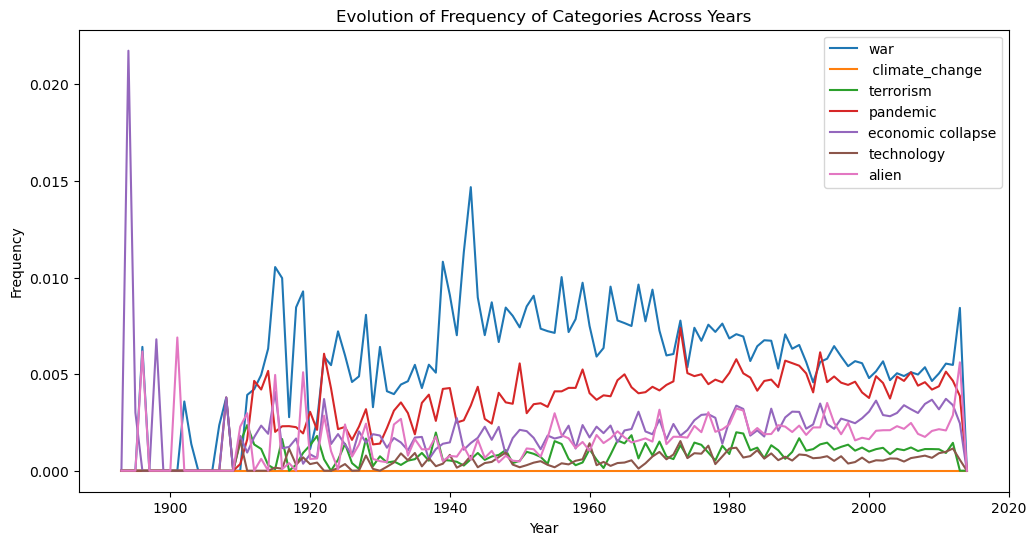

In [ ]:
# Plot evolution of frequency of every category across the years

# Group the movies by year and calculate the mean frequency for each category
category_freq_by_year = all_movies_lexicon.groupby('Movie release date')[fear_categories].mean()

# Plot the evolution of frequency for each category
plt.figure(figsize=(12, 6))
for category in fear_categories:
    plt.plot(category_freq_by_year.index, category_freq_by_year[category], label=category)

plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Evolution of Frequency of Categories Across Years')
plt.legend()
plt.show()


### Sous genre Distrib

In [ ]:
def plot_stack_plot(df, labels, xaxis, title): 
    """
    Plots a stackplot.
    """
    vstack = []
    for genre in labels: 
        vstack.append(list(df[genre]))

    vstack = np.vstack(vstack)
    fig, ax = plt.subplots()
    ax.stackplot(xaxis, vstack, labels=labels)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(title)
    plt.show()
    return ax

def to_1D(series):
    """
    Maps a list of items in a series.

    returns: pd.Series 
    """
    return pd.Series([x for _list in series for x in _list])

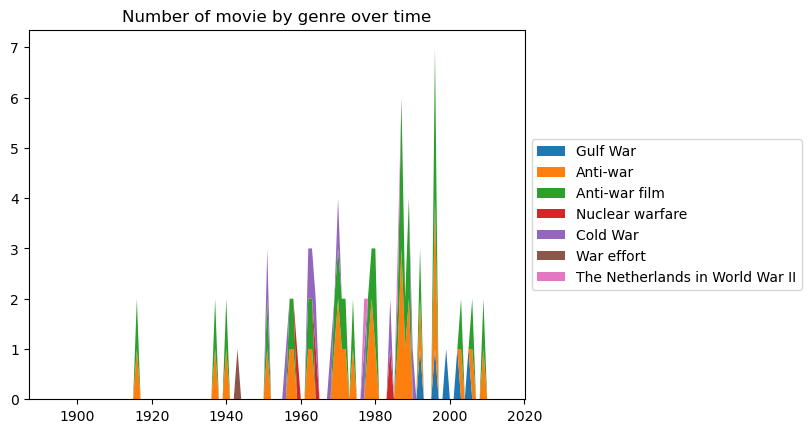

<Axes: title={'center': 'Number of movie by genre over time'}>

In [ ]:
# Prepare new dataframe for plotting 
stackplot_df = all_movies_cleaned[['Movie release date', 'Movie genres']].copy().dropna()
top_ten_list = to_1D(all_movies_cleaned['Movie genres']).value_counts()[0:10]
top_ten_genres = ['Gulf War', 'Anti-war', 'Anti-war film', 'Nuclear warfare', 'Cold War', 'War effort', 'The Netherlands in World War II']


#top_ten_genres = top_ten_list.index
for genre in top_ten_genres: 
    stackplot_df[genre] = 0

for genre in top_ten_genres:
    stackplot_df[genre] = stackplot_df['Movie genres'].apply(lambda x: 1 if genre in x else 0)

grouped_by = stackplot_df.groupby(by='Movie release date').sum().reset_index()
years = list(range(1893, 2015, 1))
plot_stack_plot(
    grouped_by, 
    top_ten_genres, 
    years, 
    'Number of movie by genre over time'
)


,Movie release date,Movie genres,Gulf War,Anti-war,Anti-war film,Nuclear warfare,Cold War,War effort,The Netherlands in World War II,sum
117,2010,"[Drama, Drama, Short Film, Documentary, Scienc...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
118,2011,"[Drama, Indie, Horror, Slasher, Documentary, R...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
119,2012,"[Disaster, Drama, Drama, Action, Fantasy, Sile...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
120,2013,"[Action, Drama, Comedy film, Drama, Comedy fil...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
121,2014,"[Drama, Fantasy, Drama, Adventure, Sci-Fi Horror]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


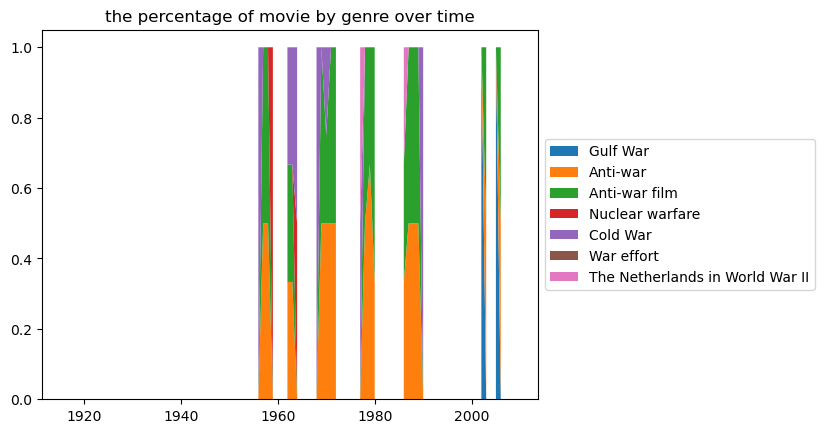

In [ ]:
percentage_df = grouped_by.copy()
percentage_df['sum'] = percentage_df.iloc[:, 2:13].sum(axis=1)
for genre in top_ten_genres:
    percentage_df[genre] = percentage_df[genre]/percentage_df['sum']

display(percentage_df.tail(5))
#plot_stack_plot(percentage_df, top_ten_genres, years, "the percentage of movie by genre over time")

vstack = []
for genre in top_ten_genres: 
    vstack.append(list(percentage_df[genre]))

vstack = np.vstack(vstack)
fig, ax = plt.subplots()
ax.stackplot(years, vstack, labels=top_ten_genres)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("the percentage of movie by genre over time")
plt.show()

### Different wars across years with lexicon

In [56]:
# Select movies for which no genre in the list 'Movie genre' contain the word "war"
all_movies_genre_war = all_movies_cleaned[all_movies_cleaned['Movie genres'].apply(lambda x: any(item for item in x if 'war' in item.lower()))]

top_10_genre = all_movies_cleaned['Movie genres'].apply(lambda x: [item for item in x if 'war' in item.lower()]).explode().unique()
print(top_10_genre)

[nan 'War film' 'Gulf War' 'Anti-war' 'Anti-war film' 'Nuclear warfare'
 'Cold War' 'War effort' 'The Netherlands in World War II']


In [ ]:
# Define terms related to World War II
''''
world_war_2_terms = ["World War II", "WWII", "Second World War", "Allied", "France", "Japan", "concentration camp"
                    "Adolf Hitler", "Hitler", "Nazism", "Holocaust", "Germany", "jewish", 'jews', "Atomic bomb"]
lexicon.create_category("ww2", world_war_2_terms, model='nytimes') 

nuclear_war_terms = ["nuclear war", "nuclear weapons", "atomic bomb", "nuclear proliferation", "destruction"]
lexicon.create_category("nuclear", nuclear_war_terms, model='nytimes')

vietnam_war_terms = ["Vietnam War", "Vietnam Conflict", "Viet Cong", "Vietnam", "Napalm", "Protest Movements", 
                     "USA", "American"]
lexicon.create_category("vietnam", vietnam_war_terms, model='nytimes') 

cold_war_terms = ["Cold War", "Iron Curtain", "Soviet Union", "United States", "USA", "NATO", "Marshall Plan", "Berlin Airlift", "Arms Race", 
                  "Space Race", "Staline", "Cuban Missile Crisis", "Berlin Wall"]
lexicon.create_category("cold", cold_war_terms, model='nytimes') 
'''
lexicon.create_category("ww2", ["Hitler", "Nazi", "Allies"], model='nytimes', size = 20) 
lexicon.create_category("nuclear", ["nuclear_war", "nuclear", "threat"], model="nytimes", size = 20)
lexicon.create_category("cold_war", ["cold_war"], model="nytimes", size = 20)
#lexicon.create_category("vietnam_war", ["vietnam"], model="nytimes", size = 10)
lexicon.create_category("war", ["war", "kil", "death"], model="nytimes", size = 20)

["Fascist", "Fascists", "Nazi", "Hitler", "Nazis", "Fatherland", "Revolutionary", "Reign", "Vietnam", "Socialist", "Islamic", "Soviet", "Propaganda", "Intellectuals", "Coup", "Condemned", "Communist", "Anti", "Terror", "Russian"]
["nuclear", "nuclear_attack", "nuclear_war", "threat", "American_security", "nuclear_proliferation", "immediate_threat", "nuclear_arms", "imminent_threat", "nuclear_threat", "nuclear_weapons", "new_threat", "nuclear_power", "new_threats", "real_threat", "military_threat", "major_threat", "serious_threat", "terrorist_threat", "military_power"]
["cold_war", "the_cold_war", "the_Cold_War", "war", "Soviet_threat", "the_end_of_the_cold_war", "Communism", "world_war", "Soviet_empire", "Soviet_power", "Communism", "gulf_war", "Soviet_bloc", "the_Soviet_Union", "communism", "superpowers", "nuclear_age", "nuclear_war", "Soviet_system", "evil_empire"]
["war", "death", "liberation", "bloodshed", "occupation", "uprising", "mass_murder", "horrors", "terror", "civil_war", "

In [ ]:
# CLEANED movie summaries
all_movies_cleaned = all_movies_cleaned.dropna(subset=['Summary'])

In [ ]:
fear_categories = ['ww2', 'nuclear', 'cold_war','war']

# New column in the dataframe that contain the frequency for every fear category defined
all_movies_lexicon = all_movies_cleaned.copy()
all_movies_lexicon['lexicon'] = all_movies_lexicon['Summary'].apply(lambda x: lexicon.analyze(x, categories=fear_categories, normalize=True))

all_movies_lexicon['lexicon']

0        {'ww2': 0.0, 'nuclear': 0.006578947368421052, ...
3        {'ww2': 0.0, 'nuclear': 0.0, 'cold_war': 0.0, ...
4        {'ww2': 0.0, 'nuclear': 0.0, 'cold_war': 0.0, ...
6        {'ww2': 0.0, 'nuclear': 0.0, 'cold_war': 0.0, ...
12       {'ww2': 0.0, 'nuclear': 0.0, 'cold_war': 0.0, ...
                               ...                        
81728    {'ww2': 0.0, 'nuclear': 0.0, 'cold_war': 0.0, ...
81731    {'ww2': 0.0, 'nuclear': 0.0, 'cold_war': 0.0, ...
81732    {'ww2': 0.0, 'nuclear': 0.0, 'cold_war': 0.0, ...
81734    {'ww2': 0.0, 'nuclear': 0.0125, 'cold_war': 0....
81735    {'ww2': 0.0, 'nuclear': 0.0, 'cold_war': 0.0, ...
Name: lexicon, Length: 42204, dtype: object

In [ ]:
# Create a new column for each category
for category in fear_categories:
    all_movies_lexicon['{}'.format(category)] = all_movies_lexicon['lexicon'].apply(lambda x: x['{}'.format(category)])

all_movies_lexicon = all_movies_lexicon.drop('lexicon', axis=1)



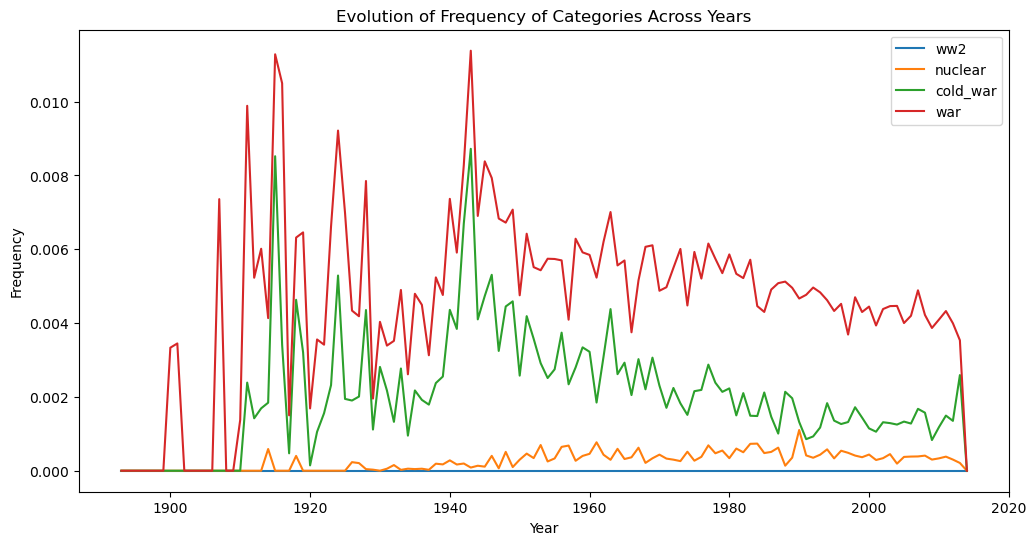

In [ ]:
# Plot evolution of frequency of every category across the years

# Group the movies by year and calculate the mean frequency for each category
category_freq_by_year = all_movies_lexicon.groupby('Movie release date')[fear_categories].mean()

# Plot the evolution of frequency for each category
plt.figure(figsize=(12, 6))
for category in fear_categories:
    plt.plot(category_freq_by_year.index, category_freq_by_year[category], label=category)

plt.xlabel('Year')
plt.ylabel('Frequency')
#axe x between 1880 and 2000
plt.title('Evolution of Frequency of Categories Across Years')
plt.legend()
plt.show()

In [ ]:
'''# Plot evolution of frequency of every category across the years

# Group the movies by year and calculate the mean frequency for each category
category_freq_by_year = all_movies_lexicon.groupby('Movie release date')[fear_categories].mean()

# Plot the evolution of frequency for each category
plt.figure(figsize=(12, 6))
for category in fear_categories:
    plt.plot(category_freq_by_year.index, category_freq_by_year[category], label=category)

plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Evolution of Frequency of Categories Across Years')
plt.legend()
plt.show()'''

"# Plot evolution of frequency of every category across the years\n\n# Group the movies by year and calculate the mean frequency for each category\ncategory_freq_by_year = all_movies_lexicon.groupby('Movie release date')[fear_categories].mean()\n\n# Plot the evolution of frequency for each category\nplt.figure(figsize=(12, 6))\nfor category in fear_categories:\n    plt.plot(category_freq_by_year.index, category_freq_by_year[category], label=category)\n\nplt.xlabel('Year')\nplt.ylabel('Frequency')\nplt.title('Evolution of Frequency of Categories Across Years')\nplt.legend()\nplt.show()"

In [ ]:
'''# CLEANED movie summaries
all_movies_cleaned = all_movies_cleaned.dropna(subset=['Movie countries'])
all_movies_cleaned.head()
all_movies_usa = all_movies_cleaned[all_movies_cleaned['Movie countries'].apply(lambda countries: 'United States of America' in countries)]
all_movies_usa.head(50)

all_movies_india = all_movies_cleaned[all_movies_cleaned['Movie countries'].apply(lambda countries: 'India' in countries)]
all_movies_india.head(50)


# New column in the dataframe that contain the frequency for every fear category defined
all_movies_lexicon_usa = all_movies_usa.copy()
all_movies_lexicon_usa['lexicon'] = all_movies_lexicon_usa['Summary'].apply(lambda x: lexicon.analyze(x, categories=fear_categories, normalize=True))

all_movies_lexicon_india = all_movies_india.copy()
all_movies_lexicon_india['lexicon'] = all_movies_lexicon_india['Summary'].apply(lambda x: lexicon.analyze(x, categories=fear_categories, normalize=True))

# Create a new column for each category
for category in fear_categories:
    all_movies_lexicon_usa['{}'.format(category)] = all_movies_lexicon_usa['lexicon'].apply(lambda x: x['{}'.format(category)])
    all_movies_lexicon_india['{}'.format(category)] = all_movies_lexicon_india['lexicon'].apply(lambda x: x['{}'.format(category)])
    
all_movies_lexicon_usa = all_movies_lexicon_usa.drop('lexicon', axis=1)
all_movies_lexicon_india = all_movies_lexicon_india.drop('lexicon', axis=1)

# Plot evolution of frequency of every category across the years

# Group the movies by year and calculate the mean frequency for each category
category_freq_by_year_usa = all_movies_lexicon_usa.groupby('Movie release date')[fear_categories].mean()
category_freq_by_year_india = all_movies_lexicon_india.groupby('Movie release date')[fear_categories].mean()

# Plot the evolution of frequency for each category
plt.figure(figsize=(12, 6))
for category in fear_categories:
    plt.plot(category_freq_by_year_usa.index, category_freq_by_year_usa[category], label=category)
    plt.plot(category_freq_by_year_india.index, category_freq_by_year_india[category], label=category)
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Evolution of Frequency of Categories Across Years for USA and India')
plt.legend()
plt.show()'''

"# CLEANED movie summaries\nall_movies_cleaned = all_movies_cleaned.dropna(subset=['Movie countries'])\nall_movies_cleaned.head()\nall_movies_usa = all_movies_cleaned[all_movies_cleaned['Movie countries'].apply(lambda countries: 'United States of America' in countries)]\nall_movies_usa.head(50)\n\nall_movies_india = all_movies_cleaned[all_movies_cleaned['Movie countries'].apply(lambda countries: 'India' in countries)]\nall_movies_india.head(50)\n\n\n# New column in the dataframe that contain the frequency for every fear category defined\nall_movies_lexicon_usa = all_movies_usa.copy()\nall_movies_lexicon_usa['lexicon'] = all_movies_lexicon_usa['Summary'].apply(lambda x: lexicon.analyze(x, categories=fear_categories, normalize=True))\n\nall_movies_lexicon_india = all_movies_india.copy()\nall_movies_lexicon_india['lexicon'] = all_movies_lexicon_india['Summary'].apply(lambda x: lexicon.analyze(x, categories=fear_categories, normalize=True))\n\n# Create a new column for each category\nfor c

In [ ]:
'''all_movies_lexicon_usa = all_movies_lexicon_usa.dropna(subset=['Movie release date'])
all_movies_lexicon_india = all_movies_lexicon_india.dropna(subset=['Movie release date'])
# Group the movies by decade and calculate the mean frequency for each category
all_movies_lexicon_usa['Movie release date'] = all_movies_lexicon_usa['Movie release date'].astype(int)
all_movies_lexicon_usa['Decade'] = all_movies_lexicon_usa['Movie release date'].apply(lambda x: x- (x % 10))
category_freq_by_decade_usa = all_movies_lexicon_usa.groupby('Decade')[fear_categories].mean() 

# Group the movies by decade and calculate the mean frequency for each category
all_movies_lexicon_india['Movie release date'] = all_movies_lexicon_india['Movie release date'].astype(int)
all_movies_lexicon_india['Decade'] = all_movies_lexicon_india['Movie release date'].apply(lambda x: x- (x % 10))
category_freq_by_decade_india = all_movies_lexicon_india.groupby('Decade')[fear_categories].mean()


# Plot the evolution of frequency for each category
plt.figure(figsize=(12, 6))
for category in fear_categories:
    plt.plot(category_freq_by_decade_usa.index, category_freq_by_decade_usa[category], label=category)
    plt.plot(category_freq_by_decade_india.index, category_freq_by_decade_india[category], label=category)
    plt.axvline(1939, color='gray', linestyle='--', alpha=0.8, label='WW2')
    plt.axvline(1945, color='gray', linestyle='--', alpha=0.8, label='WW2')
    plt.axvline(1947, color='green', linestyle='--', alpha=0.8, label='Cold War')
    plt.axvline(1991, color='green', linestyle='--', alpha=0.8, label='Cold War')

plt.xlabel('Decade')
plt.xticks(np.arange(1890, 2020, 10))
plt.ylabel('Frequency')
plt.title('Evolushow()'''

"all_movies_lexicon_usa = all_movies_lexicon_usa.dropna(subset=['Movie release date'])\nall_movies_lexicon_india = all_movies_lexicon_india.dropna(subset=['Movie release date'])\n# Group the movies by decade and calculate the mean frequency for each category\nall_movies_lexicon_usa['Movie release date'] = all_movies_lexicon_usa['Movie release date'].astype(int)\nall_movies_lexicon_usa['Decade'] = all_movies_lexicon_usa['Movie release date'].apply(lambda x: x- (x % 10))\ncategory_freq_by_decade_usa = all_movies_lexicon_usa.groupby('Decade')[fear_categories].mean() \n\n# Group the movies by decade and calculate the mean frequency for each category\nall_movies_lexicon_india['Movie release date'] = all_movies_lexicon_india['Movie release date'].astype(int)\nall_movies_lexicon_india['Decade'] = all_movies_lexicon_india['Movie release date'].apply(lambda x: x- (x % 10))\ncategory_freq_by_decade_india = all_movies_lexicon_india.groupby('Decade')[fear_categories].mean()\n\n\n# Plot the evoluti

### War across years for USA and India SUCCESS

In [37]:
path = '../data/'
all_movies_cleaned, character_metadata_cleaned, name_clusters_cleaned = get_cleaned_data(path)

# CLEANED movie summaries
all_movies_cleaned = all_movies_cleaned.dropna(subset=['Summary'])

Loading the data...


Loading and cleaning the summaries...
Summaries loaded from processed_summaries.tsv
Cleaning the data...
Adding IMDb ratings...


In [40]:
# Define terms related to war 
war_terms = ["war", "conflict", "battle", "combat", "military",  "soldier", "army", "weapons", "violence", "warfare", "casualties", "peacekeeping"]
# Create a category for "war" in the lexicon 
lexicon.create_category('War Lexicon', war_terms)

fear_categories = ['War Lexicon']

["battle", "war", "army", "armies", "rebels", "Objects", "legions", "forces", "legion", "raids", "Empire", "fighters", "battlefield", "battles", "invaders", "rebellion", "Romans", "allies", "Germans", "assassins", "military", "tribes", "leadership", "ranks", "front_lines", "Titans", "opposition", "troops", "mercenaries", "weaponry", "soldiers", "mages", "wars", "warriors", "Knights", "camps", "colony", "magicians", "Lycans", "bloodshed", "enemy", "enemies", "Object", "Alliance", "generals", "organization", "Marines", "front_line", "platoon", "knights", "Hunters", "warfare", "empire", "brethren", "Brotherhood", "terrorists", "mercenary", "Army", "raiders", "comrades", "tribe", "Elders", "nation", "Council", "casualties", "Empire", "killing", "Greeks", "commander", "region", "commanders", "giants", "Carpathians", "assassination", "marines", "Nazis", "Rogues", "clans", "civilians", "Elves", "raid", "mutants", "revolution", "pirates", "nations", "fleet", "government", "slaughter", "Nubians

In [41]:
all_movies_cleaned = all_movies_cleaned.dropna(subset=['Movie countries'])
all_movies_usa = all_movies_cleaned[all_movies_cleaned['Movie countries'].apply(lambda countries: 'United States of America' in countries)]
all_movies_india = all_movies_cleaned[all_movies_cleaned['Movie countries'].apply(lambda countries: 'India' in countries)]

# New column in the dataframe that contain the frequency for every fear category defined
all_movies_lexicon_usa = all_movies_usa.copy()
all_movies_lexicon_usa['lexicon'] = all_movies_lexicon_usa['Summary'].apply(lambda x: lexicon.analyze(x, categories=fear_categories, normalize=True))

all_movies_lexicon_india = all_movies_india.copy()
all_movies_lexicon_india['lexicon'] = all_movies_lexicon_india['Summary'].apply(lambda x: lexicon.analyze(x, categories=fear_categories, normalize=True))

# Create a new column for each category
for category in fear_categories:
    all_movies_lexicon_usa['{}'.format(category)] = all_movies_lexicon_usa['lexicon'].apply(lambda x: x['{}'.format(category)])
    all_movies_lexicon_india['{}'.format(category)] = all_movies_lexicon_india['lexicon'].apply(lambda x: x['{}'.format(category)])
    
all_movies_lexicon_usa = all_movies_lexicon_usa.drop('lexicon', axis=1)
all_movies_lexicon_india = all_movies_lexicon_india.drop('lexicon', axis=1)

all_movies_lexicon_usa = all_movies_lexicon_usa.dropna(subset=['Movie release date'])
all_movies_lexicon_india = all_movies_lexicon_india.dropna(subset=['Movie release date'])

# Group the movies by 5 years and calculate the mean frequency for each category
all_movies_lexicon_usa['Movie release date'] = all_movies_lexicon_usa['Movie release date'].astype(int)
all_movies_lexicon_usa['Decade'] = all_movies_lexicon_usa['Movie release date'].apply(lambda x: x- (x % 5))
category_freq_by_decade_usa = all_movies_lexicon_usa.groupby('Decade')[fear_categories].mean() 

# Group the movies by 5 years and calculate the mean frequency for each category
all_movies_lexicon_india['Movie release date'] = all_movies_lexicon_india['Movie release date'].astype(int)
all_movies_lexicon_india['Decade'] = all_movies_lexicon_india['Movie release date'].apply(lambda x: x- (x % 5))
category_freq_by_decade_india = all_movies_lexicon_india.groupby('Decade')[fear_categories].mean()

In [42]:
#same with plotly

fig = go.Figure()
fig.add_trace(go.Scatter(x=category_freq_by_decade_usa.index, y=category_freq_by_decade_usa['War Lexicon'], name='War Lexicon', line=dict(color='black')))
fig.add_trace(go.Scatter(x=[1914, 1918], y=[0.010, 0.010], fill='tozeroy', mode='none', fillcolor='rgba(0,100,80,0.2)', showlegend=False))
fig.add_trace(go.Scatter(x=[1939, 1945], y=[0.010, 0.010], fill='tozeroy', mode='none', fillcolor='rgba(0,176,246,0.2)', showlegend=False))
fig.add_trace(go.Scatter(x=[1947, 1991], y=[0.010, 0.010], fill='tozeroy', mode='none', fillcolor='rgba(231,107,243,0.2)', showlegend=False))
fig.add_trace(go.Scatter(x=[1914, 1914], y=[0.00, 0.010], mode='lines', line=dict(color='rgb(0,100,80)', dash='dash'), name='WW1'))
fig.add_trace(go.Scatter(x=[1918, 1918], y=[0.00, 0.010], mode='lines', line=dict(color='rgb(0,100,80)', dash='dash'), showlegend=False))
fig.add_trace(go.Scatter(x=[1939, 1939], y=[0.000, 0.010], mode='lines', line=dict(color='rgb(0,176,246)', dash='dash'), name='WW2'))
fig.add_trace(go.Scatter(x=[1945, 1945], y=[0.000, 0.010], mode='lines', line=dict(color='rgb(0,176,246)', dash='dash'), showlegend=False))
fig.add_trace(go.Scatter(x=[1947, 1947], y=[0.000, 0.010], mode='lines', line=dict(color='rgb(231,107,243)', dash='dash'), name='Cold War'))
fig.add_trace(go.Scatter(x=[1991, 1991], y=[0.000, 0.010], mode='lines', line=dict(color='rgb(231,107,243)', dash='dash'), showlegend=False))
fig.update_layout(title='Frequency of the War Lexicon in American movies for every five years period',
                   xaxis_title='Time [Years]',
                   yaxis_title='Frequency of the War Lexicon [-]',
                   xaxis=dict(
        tickmode = 'array',
        ticktext = ['1914', '1918', '1939', '1945', '1947', '1991']
    ))
fig.show()

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/clarawetzel/anaconda3/envs/ada/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/clarawetzel/anaconda3/envs/ada/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
_pickle.UnpicklingError: pickle data was truncated


### India and nuclear


In [52]:
#same with plotly

fig = go.Figure()
fig.add_trace(go.Scatter(x=category_freq_by_decade_india.index, y=category_freq_by_decade_india['War Lexicon'], name='War Lexicon', line=dict(color='black')))
fig.add_trace(go.Scatter(x=[1947, 1948], y=[0.007, 0.007], fill='tozeroy', mode='none', fillcolor='rgba(0,100,80,0.2)', showlegend=False))
fig.add_trace(go.Scatter(x=[1999, 1999], y=[0.007, 0.007], fill='tozeroy', mode='none', fillcolor='rgba(231,107,243,0.2)', showlegend=False))
fig.add_trace(go.Scatter(x=[1947, 1947], y=[0.00, 0.007], mode='lines', line=dict(color='rgb(0,100,80)', dash='dash'), name='First war Between India and Pakistan'))
fig.add_trace(go.Scatter(x=[1948, 1948], y=[0.00, 0.007], mode='lines', line=dict(color='rgb(0,100,80)', dash='dash'), showlegend=False))
fig.add_trace(go.Scatter(x=[1965, 1965], y=[0.000, 0.007], mode='lines', line=dict(color='rgb(0,176,246)', dash='dash'), name='Second war Between India and Pakistan'))
fig.add_trace(go.Scatter(x=[1971, 1971], y=[0.000, 0.007], mode='lines', line=dict(color='rgb(255, 165, 0)', dash='dash'), name='Third war Between India and Pakistan'))
fig.add_trace(go.Scatter(x=[1999, 1999], y=[0.000, 0.007], mode='lines', line=dict(color='rgb(231,107,243)', dash='dash'), name='Kargil War'))
fig.update_layout(title='Frequency of the War Lexicon in Indian movies for every five years period',
                   xaxis_title='Time [Years]',
                   yaxis_title='Frequency of the War Lexicon [-]')
                   
fig.show()

In [44]:
'''nuclear_war_terms = ["nuclear war", "nuclear weapons", "atomic bomb", "nuclear proliferation", "destruction"]
#lexicon.create_category("nuclear", nuclear_war_terms, model='nytimes')
lexicon.create_category("nuclear", ["nuclear_war", "nuclear", "threat"], model="nytimes", size = 20)
fear_categories = ['nuclear']'''

'nuclear_war_terms = ["nuclear war", "nuclear weapons", "atomic bomb", "nuclear proliferation", "destruction"]\n#lexicon.create_category("nuclear", nuclear_war_terms, model=\'nytimes\')\nlexicon.create_category("nuclear", ["nuclear_war", "nuclear", "threat"], model="nytimes", size = 20)\nfear_categories = [\'nuclear\']'

In [45]:
''''all_movies_cleaned = all_movies_cleaned.dropna(subset=['Movie countries'])
all_movies_usa = all_movies_cleaned[all_movies_cleaned['Movie countries'].apply(lambda countries: 'United States of America' in countries)]

# New column in the dataframe that contain the frequency for every fear category defined
all_movies_lexicon_usa = all_movies_usa.copy()
all_movies_lexicon_usa['lexicon'] = all_movies_lexicon_usa['Summary'].apply(lambda x: lexicon.analyze(x, categories=fear_categories, normalize=True))

# Create a new column for each category
for category in fear_categories:
    all_movies_lexicon_usa['{}'.format(category)] = all_movies_lexicon_usa['lexicon'].apply(lambda x: x['{}'.format(category)])
    
all_movies_lexicon_usa = all_movies_lexicon_usa.drop('lexicon', axis=1)

all_movies_lexicon_usa = all_movies_lexicon_usa.dropna(subset=['Movie release date'])

# Group the movies by 5 years and calculate the mean frequency for each category
all_movies_lexicon_usa['Movie release date'] = all_movies_lexicon_usa['Movie release date'].astype(int)
all_movies_lexicon_usa['Decade'] = all_movies_lexicon_usa['Movie release date'].apply(lambda x: x- (x % 5))
category_freq_by_decade_usa = all_movies_lexicon_usa.groupby('Decade')[fear_categories].mean() '''


"'all_movies_cleaned = all_movies_cleaned.dropna(subset=['Movie countries'])\nall_movies_usa = all_movies_cleaned[all_movies_cleaned['Movie countries'].apply(lambda countries: 'United States of America' in countries)]\n\n# New column in the dataframe that contain the frequency for every fear category defined\nall_movies_lexicon_usa = all_movies_usa.copy()\nall_movies_lexicon_usa['lexicon'] = all_movies_lexicon_usa['Summary'].apply(lambda x: lexicon.analyze(x, categories=fear_categories, normalize=True))\n\n# Create a new column for each category\nfor category in fear_categories:\n    all_movies_lexicon_usa['{}'.format(category)] = all_movies_lexicon_usa['lexicon'].apply(lambda x: x['{}'.format(category)])\n    \nall_movies_lexicon_usa = all_movies_lexicon_usa.drop('lexicon', axis=1)\n\nall_movies_lexicon_usa = all_movies_lexicon_usa.dropna(subset=['Movie release date'])\n\n# Group the movies by 5 years and calculate the mean frequency for each category\nall_movies_lexicon_usa['Movie re

In [46]:
'''plt.figure(figsize=(12, 6))
for category in fear_categories:
    plt.plot(category_freq_by_decade_usa.index, category_freq_by_decade_usa[category], label=category)
    plt.axvline(1986, color='blue', linestyle='--', alpha=0.8, label='Chernobyl')
    plt.axvline(1939, color='gray', linestyle='--', alpha=0.8, label='WW2')
    plt.axvline(1945, color='gray', linestyle='--', alpha=0.8)
    plt.axvline(1947, color='green', linestyle='--', alpha=0.8, label='Cold War')
    plt.axvline(1991, color='green', linestyle='--', alpha=0.8)
    

plt.xlabel('Decade')
plt.xticks(np.arange(1890, 2020, 10))
plt.ylabel('Frequency')
plt.title('USA : Evolution of Frequency of Nuclear for a every five years period')
plt.legend()
plt.show()'''

"plt.figure(figsize=(12, 6))\nfor category in fear_categories:\n    plt.plot(category_freq_by_decade_usa.index, category_freq_by_decade_usa[category], label=category)\n    plt.axvline(1986, color='blue', linestyle='--', alpha=0.8, label='Chernobyl')\n    plt.axvline(1939, color='gray', linestyle='--', alpha=0.8, label='WW2')\n    plt.axvline(1945, color='gray', linestyle='--', alpha=0.8)\n    plt.axvline(1947, color='green', linestyle='--', alpha=0.8, label='Cold War')\n    plt.axvline(1991, color='green', linestyle='--', alpha=0.8)\n    \n\nplt.xlabel('Decade')\nplt.xticks(np.arange(1890, 2020, 10))\nplt.ylabel('Frequency')\nplt.title('USA : Evolution of Frequency of Nuclear for a every five years period')\nplt.legend()\nplt.show()"

# Sentiment analysis

In [53]:
#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

In [57]:
#sentiment analysis of the summary
all_movies_genre_war['sentiment'] = all_movies_genre_war['Summary'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
all_movies_cleaned['sentiment'] = all_movies_cleaned['Summary'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

/var/folders/60/n3wml7t139732y5n5jgc1bqc0000gn/T/ipykernel_40088/2060848110.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [59]:
# Calculate histogram with fixed bin edges for all_movies_genre_war
counts_war, bin_edges_war = np.histogram(all_movies_genre_war['sentiment'], bins=20)
percentages_war = counts_war / len(all_movies_genre_war) * 100
bin_midpoints_war = (bin_edges_war[:-1] + bin_edges_war[1:]) / 2
histogram_data_war = pd.DataFrame({'Bin Midpoints': bin_midpoints_war, 'Percentage': percentages_war})

# Calculate histogram with fixed bin edges for all_movies_cleaned
counts_all, bin_edges_all = np.histogram(all_movies_cleaned['sentiment'], bins=20)
percentages_all = counts_all / len(all_movies_cleaned) * 100
bin_midpoints_all = (bin_edges_all[:-1] + bin_edges_all[1:]) / 2
histogram_data_all = pd.DataFrame({'Bin Midpoints': bin_midpoints_all, 'Percentage': percentages_all})

# Create subplots
fig = sp.make_subplots(rows=1, cols=2, subplot_titles=['War Movies', 'All Movies'])

# Add bar chart for all_movies_genre_war
fig.add_trace(go.Bar(x=histogram_data_war['Bin Midpoints'], y=histogram_data_war['Percentage'], name='War Movies', marker_color='rgb(0, 114, 178)'),
              row=1, col=1)
fig.update_xaxes(title_text='Compound sentiment', row=1, col=1)
fig.update_yaxes(title_text='Movie Percentage [%]', row=1, col=1)  # Custom tick format

# Add bar chart for all_movies_cleaned
fig.add_trace(go.Bar(x=histogram_data_all['Bin Midpoints'], y=histogram_data_all['Percentage'], name='All Movies', marker_color='rgb(230, 159, 0)'),
              row=1, col=2)
fig.update_xaxes(title_text='Compound sentiment', row=1, col=2)
fig.update_yaxes(title_text='Movie Percentage [%]', row=1, col=2)  # Custom tick format

# Update layout
fig.update_layout(
   title_text='Histogram of Compound sentiment for war and all movies',
    showlegend=False  # To show legend only once for both subplots
)

fig.show()

Let's perform a two-sided test for the null hypothesis that the war movies and all the movies have identical compound sentiment average (expected) values. 

In [60]:
#t-test to compare the two compound sentiment distributions
from scipy.stats import ttest_ind
print(ttest_ind(all_movies_genre_war['sentiment'], all_movies_cleaned['sentiment']))

TtestResult(statistic=-16.506914177361047, pvalue=5.006863490509746e-61, df=43767.0)


The p value is a lot smaller than 0.05, we can reject the null hypothesis that the compound sentiment value is the same

In [61]:
all_movies_cleaned = all_movies_cleaned.dropna(subset=['Movie release date'])
all_movies_genre_war = all_movies_genre_war.dropna(subset=['Movie release date'])

# Group the movies by year and calculate the mean frequency for each category
category_freq_by_year_all = all_movies_cleaned.groupby('Movie release date')[['sentiment']].mean()
category_freq_by_year_war = all_movies_genre_war.groupby('Movie release date')[['sentiment']].mean()

# Group the movies by 5 years and calculate the mean frequency for each category
all_movies_cleaned['Movie release date'] = all_movies_cleaned['Movie release date'].astype(int)
all_movies_cleaned['Decade'] = all_movies_cleaned['Movie release date'].apply(lambda x: x- (x % 5))
category_freq_by_decade_all = all_movies_cleaned.groupby('Decade')[['sentiment']].mean()

all_movies_genre_war['Movie release date'] = all_movies_genre_war['Movie release date'].astype(int)
all_movies_genre_war['Decade'] = all_movies_genre_war['Movie release date'].apply(lambda x: x- (x % 5))
category_freq_by_decade_war = all_movies_genre_war.groupby('Decade')[['sentiment']].mean()

# same with plotly
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
fig.add_trace(go.Scatter(x=category_freq_by_decade_all.index, y=category_freq_by_decade_all['sentiment'], name='All movies',  marker_color='rgb(0, 114, 178)'))
fig.add_trace(go.Scatter(x=category_freq_by_decade_war.index, y=category_freq_by_decade_war['sentiment'], name='War movies',  marker_color='rgb(230, 159, 0)'))
fig.add_vline(x=1939, line_width=3, line_dash="dash", line_color="gray", annotation_text="WW2")
fig.add_vline(x=1945, line_width=3, line_dash="dash", line_color="gray")
fig.update_layout(title='Evolution of Compound Sentiment Across Years', xaxis_title='Year', yaxis_title='Compound sentiment')
fig.show()



# Ratings

In [ ]:
'''import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go

# Calculate histogram with fixed bin edges for all_movies_genre_war
counts_war, bin_edges_war = np.histogram(all_movies_genre_war['averageRating'], bins=20)
percentages_war = counts_war / len(all_movies_genre_war) 
bin_midpoints_war = (bin_edges_war[:-1] + bin_edges_war[1:]) / 2
histogram_data_war = pd.DataFrame({'Bin Midpoints': bin_midpoints_war, 'Percentage': percentages_war})

# Calculate histogram with fixed bin edges for all_movies_cleaned
counts_all, bin_edges_all = np.histogram(all_movies_cleaned['averageRating'], bins=20)
percentages_all = counts_all / len(all_movies_cleaned) 
bin_midpoints_all = (bin_edges_all[:-1] + bin_edges_all[1:]) / 2
histogram_data_all = pd.DataFrame({'Bin Midpoints': bin_midpoints_all, 'Percentage': percentages_all})

# Create subplots
fig = sp.make_subplots(rows=1, cols=2, subplot_titles=['War Movies', 'All Movies'])

# Add bar chart for all_movies_genre_war
fig.add_trace(go.Bar(x=histogram_data_war['Bin Midpoints'], y=histogram_data_war['Percentage'], name='War Movies'),
              row=1, col=1)
fig.update_xaxes(title_text='Average Rating', row=1, col=1)
fig.update_yaxes(title_text='Percentage', row=1, col=1, tickformat='%.0f')


# Add bar chart for all_movies_cleaned
fig.add_trace(go.Bar(x=histogram_data_all['Bin Midpoints'], y=histogram_data_all['Percentage'], name='All Movies'),
              row=1, col=2)
fig.update_layout(yaxis_tickformat='%')
fig.update_xaxes(title_text='Average Rating', row=1, col=2)
fig.update_yaxes(title_text='Percentage', row=1, col=2, tickformat='%')


# Update layout
fig.update_layout(
   title_text='Histogram of Average Ratings for war and all movies',
    showlegend=False  # To show legend only once for both subplots
)

fig.show()'''



"import plotly.express as px\nimport plotly.subplots as sp\nimport plotly.graph_objects as go\n\n# Calculate histogram with fixed bin edges for all_movies_genre_war\ncounts_war, bin_edges_war = np.histogram(all_movies_genre_war['averageRating'], bins=20)\npercentages_war = counts_war / len(all_movies_genre_war) \nbin_midpoints_war = (bin_edges_war[:-1] + bin_edges_war[1:]) / 2\nhistogram_data_war = pd.DataFrame({'Bin Midpoints': bin_midpoints_war, 'Percentage': percentages_war})\n\n# Calculate histogram with fixed bin edges for all_movies_cleaned\ncounts_all, bin_edges_all = np.histogram(all_movies_cleaned['averageRating'], bins=20)\npercentages_all = counts_all / len(all_movies_cleaned) \nbin_midpoints_all = (bin_edges_all[:-1] + bin_edges_all[1:]) / 2\nhistogram_data_all = pd.DataFrame({'Bin Midpoints': bin_midpoints_all, 'Percentage': percentages_all})\n\n# Create subplots\nfig = sp.make_subplots(rows=1, cols=2, subplot_titles=['War Movies', 'All Movies'])\n\n# Add bar chart for all

In [63]:
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go

#drop na
all_movies_cleaned = all_movies_cleaned.dropna(subset=['averageRating'])
all_movies_genre_war = all_movies_genre_war.dropna(subset=['averageRating'])

# Calculate histogram with fixed bin edges for all_movies_genre_war
counts_war, bin_edges_war = np.histogram(all_movies_genre_war['averageRating'], bins=20)
percentages_war = counts_war / len(all_movies_genre_war) * 100
bin_midpoints_war = (bin_edges_war[:-1] + bin_edges_war[1:]) / 2
histogram_data_war = pd.DataFrame({'Bin Midpoints': bin_midpoints_war, 'Percentage': percentages_war})

# Calculate histogram with fixed bin edges for all_movies_cleaned
counts_all, bin_edges_all = np.histogram(all_movies_cleaned['averageRating'], bins=20)
percentages_all = counts_all / len(all_movies_cleaned) * 100
bin_midpoints_all = (bin_edges_all[:-1] + bin_edges_all[1:]) / 2
histogram_data_all = pd.DataFrame({'Bin Midpoints': bin_midpoints_all, 'Percentage': percentages_all})

# Create subplots
fig = sp.make_subplots(rows=1, cols=2, subplot_titles=['War Movies', 'All Movies'])

# Add bar chart for all_movies_genre_war
fig.add_trace(go.Bar(x=histogram_data_war['Bin Midpoints'], y=histogram_data_war['Percentage'], name='War Movies', marker_color='rgb(0, 114, 178)'),
              row=1, col=1)
fig.update_xaxes(title_text='Average Rating', range=[0, 10], row=1, col=1)
fig.update_yaxes(title_text='Percentage [%]',range=[0, 20], row=1, col=1)  # Custom tick format

# Add bar chart for all_movies_cleaned
fig.add_trace(go.Bar(x=histogram_data_all['Bin Midpoints'], y=histogram_data_all['Percentage'], name='All Movies', marker_color='rgb(230, 159, 0)'),
              row=1, col=2)
fig.update_xaxes(title_text='Average Rating', range=[0, 10], row=1, col=2)
fig.update_yaxes(title_text='Percentage [%]', range=[0, 20], row=1, col=2)  # Custom tick format

# Update layout
fig.update_layout(
   title_text='Histogram of Average Ratings for war and all movies',
    showlegend=False  # To show legend only once for both subplots
)

fig.show()


In [64]:
#t-test to compare the two average rating distributions
from scipy.stats import ttest_ind
#drop the nan values
all_movies_genre_war = all_movies_genre_war.dropna(subset=['averageRating'])
all_movies_cleaned = all_movies_cleaned.dropna(subset=['averageRating'])

print(ttest_ind(all_movies_genre_war['averageRating'], all_movies_cleaned['averageRating']))


TtestResult(statistic=15.804071797832371, pvalue=4.390443676417215e-56, df=38268.0)


In [ ]:
'''fig, ax = plt.subplots(figsize=(4, 6))

# Use Seaborn's boxplot
sns.boxplot(data=[all_movies_genre_war['averageRating'], all_movies_cleaned['averageRating']], ax=ax)

ax.set_ylim([0, 10])
ax.set_ylabel('Average rating on a 10 points scale')
ax.set_title('War movies vs All movies')
ax.set_xticklabels(['War movies', 'All movies'])

plt.show()'''

"fig, ax = plt.subplots(figsize=(4, 6))\n\n# Use Seaborn's boxplot\nsns.boxplot(data=[all_movies_genre_war['averageRating'], all_movies_cleaned['averageRating']], ax=ax)\n\nax.set_ylim([0, 10])\nax.set_ylabel('Average rating on a 10 points scale')\nax.set_title('War movies vs All movies')\nax.set_xticklabels(['War movies', 'All movies'])\n\nplt.show()"

In [66]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Box(y=all_movies_genre_war['averageRating'], name='War movies', marker_color='rgb(0, 114, 178)'))
fig.add_trace(go.Box(y=all_movies_cleaned['averageRating'], name='All movies',  marker_color='rgb(230, 159, 0)'))
fig.update_layout(title='Box plot of the average rating of war movies<br>and all movies',
                   yaxis_title='Average rating on a 10 points scale')
fig.update_layout(width=500, height=400 )
fig.show()

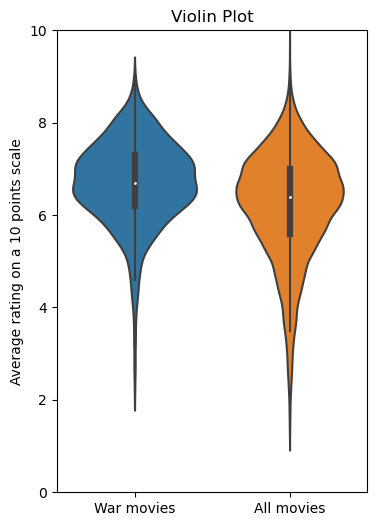

In [67]:
fig, ax = plt.subplots(figsize=(4, 6))

# Use Seaborn's boxplot
sns.violinplot(data=[all_movies_genre_war['averageRating'], all_movies_cleaned['averageRating']], ax=ax)

ax.set_ylim([0, 10])
ax.set_ylabel('Average rating on a 10 points scale')
ax.set_title('Violin Plot')
ax.set_xticklabels(['War movies', 'All movies'])

plt.show()




In [68]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Violin(y=all_movies_genre_war['averageRating'], name='War movies', marker_color='rgb(0, 114, 178)'))
fig.add_trace(go.Violin(y=all_movies_cleaned['averageRating'], name='All movies',  marker_color='rgb(230, 159, 0)'))
fig.update_layout(title='Violine plot of the average rating of war movies<br>and all movies',
                   yaxis_title='Average rating on a 10 points scale')
fig.update_layout( width=500, height=400 )
fig.show()

In [69]:
print(all_movies_genre_war['averageRating'].mean())
print(all_movies_cleaned['averageRating'].mean())

6.696605566870332
6.209052368399598


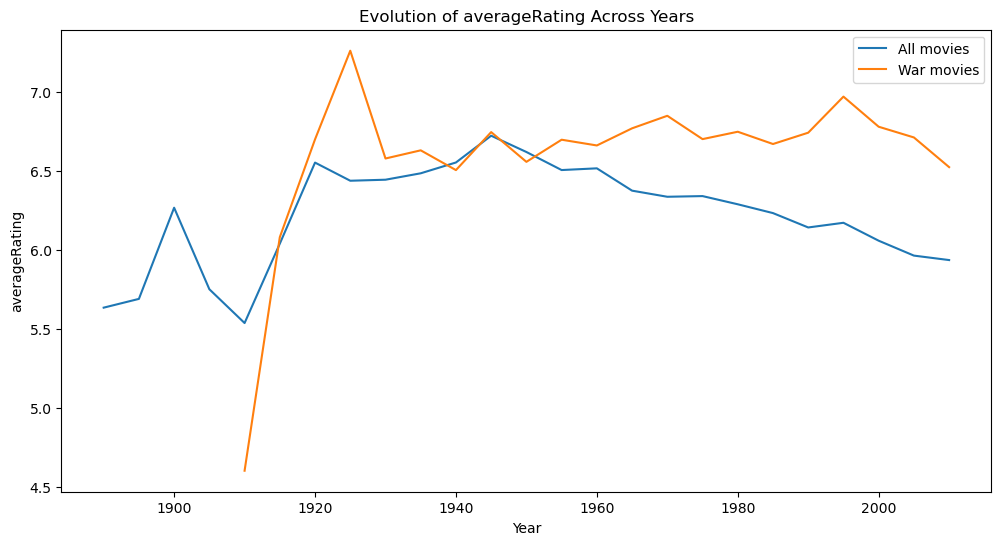

In [70]:
# Group the movies by year and calculate the mean frequency for each category
category_freq_by_year_all = all_movies_cleaned.groupby('Movie release date')[['averageRating']].mean()
category_freq_by_year_war = all_movies_genre_war.groupby('Movie release date')[['averageRating']].mean()

# Group the movies by 5 years and calculate the mean frequency for each category
all_movies_cleaned['Movie release date'] = all_movies_cleaned['Movie release date'].astype(int)
all_movies_cleaned['Decade'] = all_movies_cleaned['Movie release date'].apply(lambda x: x- (x % 5))
category_freq_by_decade_all = all_movies_cleaned.groupby('Decade')[['averageRating']].mean()

all_movies_genre_war['Movie release date'] = all_movies_genre_war['Movie release date'].astype(int)
all_movies_genre_war['Decade'] = all_movies_genre_war['Movie release date'].apply(lambda x: x- (x % 5))
category_freq_by_decade_war = all_movies_genre_war.groupby('Decade')[['averageRating']].mean()

# Plot the evolution of frequency for each category
plt.figure(figsize=(12, 6))
for category in ['averageRating']:
    plt.plot(category_freq_by_decade_all.index, category_freq_by_decade_all['averageRating'], label = 'All movies')
    plt.plot(category_freq_by_decade_war.index, category_freq_by_decade_war['averageRating'], label = 'War movies')
    
plt.xlabel('Year')
plt.ylabel('averageRating')
plt.title('Evolution of averageRating Across Years')
plt.legend()
plt.show()

## Revenue

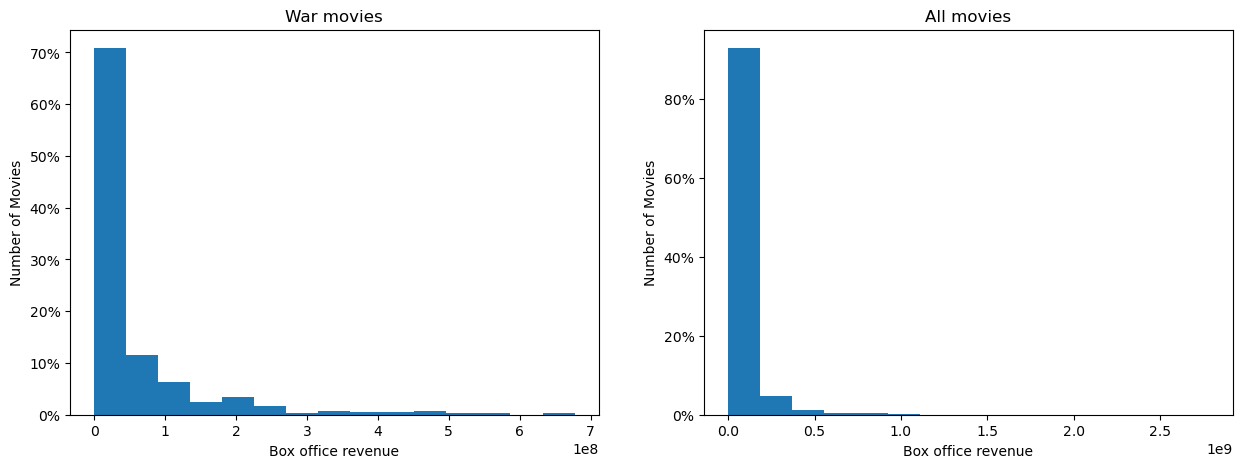

In [80]:
from matplotlib.ticker import PercentFormatter

#drop the nan values
all_movies_genre_war = all_movies_genre_war.dropna(subset=['Movie revenue'])
all_movies_cleaned = all_movies_cleaned.dropna(subset=['Movie revenue'])

#box office revenue distribution
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].hist(all_movies_genre_war['Movie revenue'],bins = 15, weights=np.ones(len(all_movies_genre_war)) / len(all_movies_genre_war))
#ax[0].set_xlim([0,100000000])
#log scale
ax[0].yaxis.set_major_formatter(PercentFormatter(1))
ax[0].set_xlabel('Box office revenue')
ax[0].set_ylabel('Number of Movies')
ax[0].set_title('War movies')
ax[1].hist(all_movies_cleaned['Movie revenue'],bins = 15,weights=np.ones(len(all_movies_cleaned)) / len(all_movies_cleaned))
#ax[1].set_xlim([0,100000000])
ax[1].yaxis.set_major_formatter(PercentFormatter(1))
ax[1].set_xlabel('Box office revenue')
ax[1].set_ylabel('Number of Movies')
ax[1].set_title('All movies')
plt.show()



In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Box(y=all_movies_genre_war['Movie revenue'], name='War movies', marker_color='rgb(0, 114, 178)'))
fig.add_trace(go.Box(y=all_movies_cleaned['Movie revenue'], name='All movies',  marker_color='rgb(230, 159, 0)'))
fig.update_layout(title='Box plot of the box office revenue of war movies<br>and all movies',
                   yaxis_title='Box office revenue [$]')
fig.update_layout(yaxis_type="log", width=500, height=400 )
fig.show()

In [ ]:
'''#boxplot
fig, ax = plt.subplots(figsize=(4, 6))

# Use Seaborn's boxplot
sns.violinplot(data=[all_movies_genre_war['Movie revenue'], all_movies_cleaned['Movie revenue']], ax=ax)

#ax.set_ylim([0, 10])
#Log y axis
#ax.set_yscale('log')
ax.set_ylabel('Average rating on a 10 points scale')
ax.set_title('War movies vs All movies')
ax.set_xticklabels(['War movies', 'All movies'])

plt.show()'''

"#boxplot\nfig, ax = plt.subplots(figsize=(4, 6))\n\n# Use Seaborn's boxplot\nsns.violinplot(data=[all_movies_genre_war['Movie revenue'], all_movies_cleaned['Movie revenue']], ax=ax)\n\n#ax.set_ylim([0, 10])\n#Log y axis\n#ax.set_yscale('log')\nax.set_ylabel('Average rating on a 10 points scale')\nax.set_title('War movies vs All movies')\nax.set_xticklabels(['War movies', 'All movies'])\n\nplt.show()"

In [ ]:
#drop the nan values
all_movies_genre_war = all_movies_genre_war.dropna(subset=['Movie revenue'])
all_movies_cleaned = all_movies_cleaned.dropna(subset=['Movie revenue'])

print(ttest_ind(all_movies_genre_war['Movie revenue'], all_movies_cleaned['Movie revenue']))

TtestResult(statistic=0.05632753105394912, pvalue=0.9550823174827578, df=7867.0)


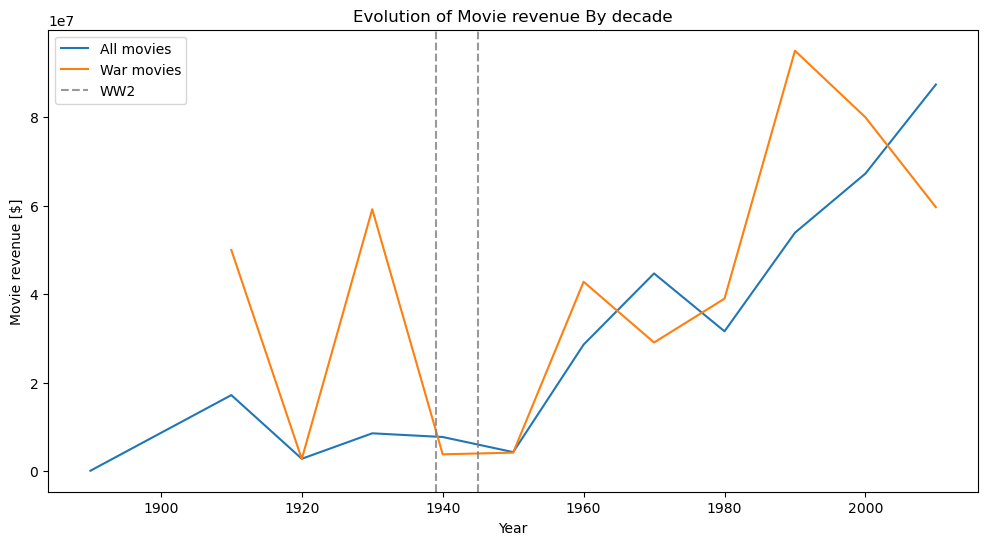

In [ ]:

# Group the movies by year and calculate the mean frequency for each category
category_freq_by_year_all = all_movies_cleaned.groupby('Movie release date')[['Movie revenue']].mean()
category_freq_by_year_war = all_movies_genre_war.groupby('Movie release date')[['Movie revenue']].mean()

# Group the movies by 5 years and calculate the mean frequency for each category
all_movies_cleaned['Movie release date'] = all_movies_cleaned['Movie release date'].astype(int)
all_movies_cleaned['Decade'] = all_movies_cleaned['Movie release date'].apply(lambda x: x- (x % 10))
category_freq_by_decade_all = all_movies_cleaned.groupby('Decade')[['Movie revenue']].mean()

all_movies_genre_war['Movie release date'] = all_movies_genre_war['Movie release date'].astype(int)
all_movies_genre_war['Decade'] = all_movies_genre_war['Movie release date'].apply(lambda x: x- (x % 10))
category_freq_by_decade_war = all_movies_genre_war.groupby('Decade')[['Movie revenue']].mean()

# Plot the evolution of frequency for each category
plt.figure(figsize=(12, 6))
for category in ['Movie revenue']:
    plt.plot(category_freq_by_decade_all.index, category_freq_by_decade_all['Movie revenue'], label = 'All movies')
    plt.plot(category_freq_by_decade_war.index, category_freq_by_decade_war['Movie revenue'], label = 'War movies')
    plt.axvline(1939, color='gray', linestyle='--', alpha=0.8, label='WW2')
    plt.axvline(1945, color='gray', linestyle='--', alpha=0.8)
    
plt.xlabel('Year')
plt.ylabel('Movie revenue [$]')
plt.title('Evolution of Movie revenue By decade')
plt.legend()
plt.show()